# Byzantine Generals Turn to Quantum
## *An hardware demo for the case of up two traitors among  four generals*



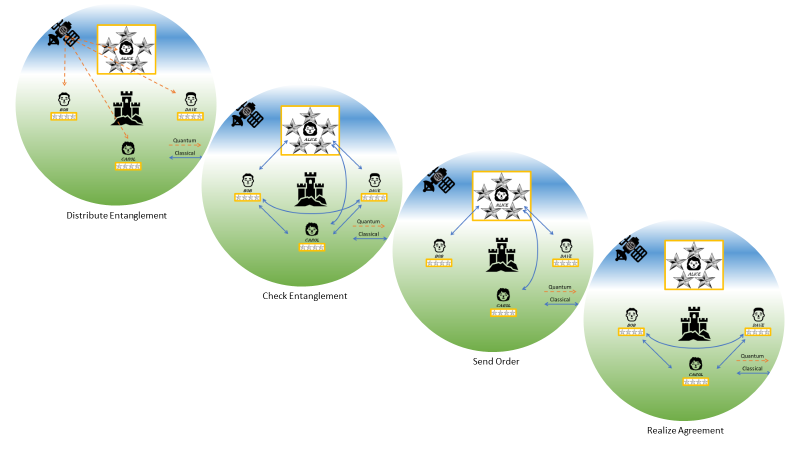
#### Notes:

This version uses a prediction of the errors in the game in function of the device, the circuit, the order, the lieutenant and his loyalty.

As an option, agreement is obtained using a Bayesian model where loyal lieutenants have an a priori estimate of each general's probability of cheating.

The "byzantine mitigation" in the case of more than 4 generals which consists of flipping half of the bitstrings is now done randomly (instead of each bitstring with an even index as mentioned in the [article published in
Geek Culture](https://medium.com/geekculture/byzantine-generals-turn-to-quantum-ab81bd938cc2)). This involves sharing between generals the indexes of the bitstrings to be flipped. The condition therefore remains that each party knows only her/his result list when ultimately realizing agreement.

In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
import copy, random, itertools
from qiskit.quantum_info.analysis import hellinger_fidelity

In [2]:
# define here the distance/distribution used to unmask traitor
from scipy.spatial.distance import sqeuclidean as distance
from scipy.stats import hypergeom

In [3]:
# parameters
noise = True
simulator = Aer.get_backend('qasm_simulator')
optimization_level = 2
shots = 8192
max_rounds = 1000
verbose_flag = False

# number of generals
N_gen = 4

# use hypergeometric distribution, or distance otherwise
hg_flag = True

In [4]:
hardware = True
redo = False # if False, skip the experiment
if hardware:
    # define backend
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='qc-spring-22-4')
    backend = provider.get_backend('ibm_nairobi') # type here hardware backend     
    
else:
    # here you can change the backends
    from qiskit.test.mock import FakeSantiago as device_3_generals
    from qiskit.test.mock import FakeCasablanca as device_4_generals    

In [5]:
# adapt to given parameters
if N_gen == 3:
    perms = list(itertools.permutations(['00','01','10'], r=3))

elif N_gen == 4:
    perms = list(itertools.permutations(['00','01','10','11'], r=4))
    
else: 
    print("only the three and four generals cases considered at this time")

In [6]:
if not hardware:
    if noise:
        if N_gen == 3:
            device = device_3_generals
        elif N_gen == 4:
            device = device_4_generals
        backend = AerSimulator.from_backend(device())
    else: # switch to the ideal device
        backend = simulator

In [7]:
backend.name()

'ibm_nairobi'

#### Prepare the state:


In case of three generals:

$$ \frac{1}{2\;\sqrt3}\; (\;2\;|0011\rangle - |0101\rangle - |0110\rangle - |1001\rangle -  |1010\rangle + 2\;|1100\rangle\;) $$


In case of four generals:


$$(\sqrt6|00111\rangle +  |01001\rangle +  |01010\rangle + |01100\rangle + |10011 \rangle +  |10101\rangle +  |10110\rangle +  \sqrt6|11100\rangle) \ /\sqrt18$$

In [8]:
if N_gen == 3:
    init_list = np.array([0., 0., 0., 2., 0., -1., -1., 0.,
             0., -1., -1., 0., 2., 0., 0., 0.]) / ( 2*np.sqrt(3) )
elif N_gen == 4:
    init_list = np.array(  [0., 0., 0., 0., 0., 0., 0., 6.**.5,
                            0., +1., +1., 0., +1., 0., 0., 0.,
                            0., 0., 0., +1., 0., +1., +1., 0.,
                            6.**.5, 0., 0., 0., 0., 0., 0., 0.]) / np.sqrt(18)
else: 
    print("only the three and four generals cases considered at this time")

In [9]:
# create the quantum circuit
circuit = QuantumCircuit(N_gen+1)

circuit.initialize(init_list, circuit.qubits)

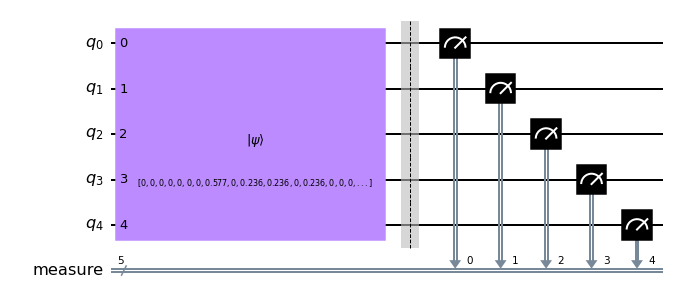

In [10]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [11]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [12]:
# byzantine traitor game serving function

def play(k_list, t_list, n_its_list, used_list, stop_flag, flag_y = None):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] == flag_y: 
        flag_2 = False

    return flag_1, flag_2

In [13]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to play is", gen[players[toss]]['name'])
    print("                        Second to play is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots:", shots )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to play
        flag[0][1], flag[1][1] = play(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag,
                                      gen[players[toss]]['flag_y'])
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to play
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = play(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag,
                                          gen[players[1-toss]]['flag_y'])

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [14]:
if redo:
    # distribute entanglement 
    if noise:
        job_ideal = execute(circuit, backend = simulator, shots = shots,                
                    optimization_level = optimization_level)

        res_ideal = job_ideal.result()
        counts_ideal = res_ideal.get_counts(circuit)

        if shots <= 200: # for checks
            verbose_flag = True

        if N_gen == 3:    
            job = execute(circuit, backend = backend, shots = shots,
            memory=True,     
            optimization_level = optimization_level)
            figsize = (14,7)

        elif N_gen == 4:
            job = execute(circuit, backend = backend, shots = shots,
            memory=True,
            optimization_level = optimization_level)
            figsize = (10,6) 

        else: 
            job = None
            print("only the three and four generals cases considered at this time")

        results = job.result()
        memory = results.get_memory(circuit)
        counts = results.get_counts(circuit)
        legend_to_plot = [simulator, backend.name()]
        counts_to_plot = [counts_ideal,counts]
        print('hellinger fidelity: {:.1%}'.format(
            hellinger_fidelity(counts_ideal,counts)))
    else:
        job_ideal = execute(circuit, backend = simulator, shots = shots,
                            memory = True,
                            optimization_level = optimization_level)
        results = job_ideal.result()
        memory = results.get_memory(circuit)
        counts = results.get_counts(circuit)
        legend_to_plot = [backend.name()]
        counts_to_plot = [counts]
        figsize = None

In [15]:
if redo:
    plot_histogram(counts_to_plot, bar_labels = False,
                   figsize = figsize,
                   legend = legend_to_plot)

### Results of example job
job: 6287eed8e2f2782d3afbb7a3

provider: qc-spring-22-4/group-4/recyKVXzKWgbSzRhc 

ibm_nairobi 

Created: May 20, 2022 9:41 PMj

Hellinger fidelity: 44.3%

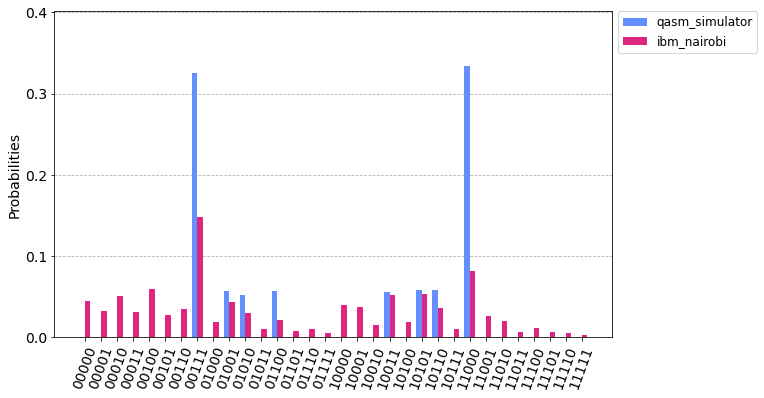

In [16]:
if not redo:
    counts = {'00000': 364, '00001': 262, '10000': 325, '10001': 303, '10010': 125, '10011': 428, '10100': 152, '10101': 441, '10110': 297, '10111': 88, '11000': 667, '11001': 219, '11010': 162, '11011': 57, '11100': 97, '11101': 53, '11110': 42, '11111': 27, '00010': 413, '00011': 259, '00100': 485, '00101': 230, '00110': 281, '00111': 1214, '01000': 151, '01001': 357, '01010': 250, '01011': 82, '01100': 176, '01101': 60, '01110': 84, '01111': 41}

In [17]:
if not redo:
    memory =  ['00111', '00101', '00000', '01001', '01100', '10101', '00100', '00010', '00011', '10110', '10011', '10010', '00110', '00111', '01000', '01110', '10101', '00001', '11100', '00100', '01010', '11000', '00111', '11000', '01000', '11001', '11000', '10001', '00111', '01010', '10011', '11000', '10110', '10110', '00001', '11000', '10001', '00010', '00000', '00010', '11110', '00010', '00010', '00111', '00010', '00100', '10011', '00110', '00111', '11000', '00111', '01111', '11000', '11010', '10011', '00000', '01010', '00111', '10110', '00000', '11000', '01100', '00100', '10000', '10001', '10011', '00001', '11110', '00110', '00010', '01010', '01000', '00100', '10000', '00100', '11000', '10101', '00111', '01011', '00110', '11001', '00000', '00110', '00111', '00100', '00111', '11000', '01011', '11000', '11010', '01000', '00111', '00010', '11000', '10000', '10000', '00000', '00111', '00001', '01001', '11000', '00101', '00111', '00111', '00111', '11001', '11011', '00101', '00100', '00001', '00100', '01101', '01001', '00011', '10011', '10110', '10101', '10110', '10101', '10000', '00111', '10100', '11000', '01001', '00010', '00101', '11000', '00011', '00001', '00010', '10101', '01100', '10011', '10001', '10101', '10000', '11000', '10010', '11000', '00100', '01110', '10011', '00111', '00111', '11000', '11011', '00100', '10011', '00111', '11010', '00010', '11111', '10110', '10001', '10000', '11000', '00000', '00000', '11000', '10011', '01001', '00101', '10001', '00111', '00000', '10111', '11011', '01100', '00111', '10101', '01011', '00000', '00010', '00100', '11000', '11111', '11001', '00111', '01010', '01010', '10001', '10001', '00000', '00011', '11000', '00010', '00100', '11001', '10011', '10011', '11101', '00110', '00110', '00111', '00111', '00101', '00010', '00100', '00101', '00011', '10101', '10001', '01001', '10011', '10000', '00000', '00100', '01110', '10101', '00111', '10001', '00100', '00010', '10011', '00011', '10011', '00111', '00010', '10100', '10000', '00111', '00000', '10101', '00000', '11000', '11010', '00010', '01001', '00100', '00111', '00101', '10000', '00111', '11010', '11010', '00100', '10000', '00111', '00111', '00111', '11000', '11000', '00111', '00000', '00011', '00010', '00111', '01011', '00111', '00101', '00001', '01010', '00110', '00010', '00110', '10101', '10001', '11001', '11010', '00111', '00001', '00011', '00111', '00111', '11100', '00111', '10101', '00100', '00110', '10011', '11110', '11000', '00101', '10110', '11100', '10001', '10011', '01110', '11000', '01111', '00111', '00010', '10101', '00001', '00111', '00001', '00111', '10100', '10011', '10011', '10110', '00110', '00111', '00010', '11010', '01001', '10101', '00000', '10011', '00010', '11010', '00110', '00010', '10100', '01001', '00001', '11000', '10100', '00000', '01001', '01100', '01000', '10101', '00011', '11001', '01001', '10100', '11000', '00001', '10100', '11000', '01101', '11000', '10001', '00010', '11000', '11010', '11000', '00111', '00001', '01001', '01001', '00110', '00110', '00000', '01001', '11011', '00111', '11000', '00111', '11111', '00111', '00110', '10001', '00100', '11010', '10101', '00111', '11000', '01000', '01011', '00111', '11100', '10011', '00101', '00100', '00100', '00111', '00111', '00010', '01100', '00101', '00100', '00111', '00111', '00011', '01010', '10011', '10000', '01101', '00101', '00100', '11000', '11010', '00001', '11000', '00111', '00010', '01000', '10011', '01011', '00000', '00000', '10101', '00010', '11000', '00111', '10011', '11100', '10001', '01110', '01111', '11001', '01100', '11000', '00111', '11000', '10011', '00000', '00100', '00111', '10001', '10110', '00100', '00111', '10011', '00000', '00111', '10000', '10100', '00000', '00101', '00100', '00100', '00010', '00111', '10011', '00011', '00000', '00111', '00111', '00111', '10101', '10011', '00111', '10001', '01010', '00100', '00101', '00000', '10101', '11100', '10011', '10000', '10011', '10000', '00111', '00111', '00111', '11010', '10100', '10010', '00111', '00111', '10000', '01001', '01000', '10000', '00110', '01001', '10010', '00010', '00100', '10110', '10100', '01001', '10001', '00110', '01001', '10011', '11011', '01000', '10001', '10000', '00111', '00010', '01110', '01011', '00010', '00111', '11101', '00111', '00110', '00100', '01001', '00111', '00111', '01010', '01010', '00000', '00001', '00101', '10101', '10001', '01110', '10011', '11010', '00010', '11000', '11001', '00011', '11000', '01011', '11000', '00111', '11000', '00010', '00000', '10000', '00010', '11000', '10001', '00010', '10011', '11001', '00100', '01001', '00000', '00110', '00111', '01001', '10110', '10011', '00111', '10101', '11001', '00111', '00100', '01101', '10001', '00010', '10001', '10101', '00011', '00101', '10101', '00001', '10011', '00010', '10110', '00010', '10100', '10101', '10011', '00000', '00111', '00100', '01011', '00101', '10100', '01100', '00010', '10110', '10100', '00000', '00000', '00111', '10010', '10011', '10000', '00111', '00111', '10000', '10001', '00111', '00101', '00111', '11010', '10110', '01001', '00010', '00100', '00111', '00001', '00110', '10101', '00100', '00100', '00111', '11000', '11001', '00101', '00010', '00000', '11010', '00010', '00111', '00110', '10011', '10000', '00111', '01001', '00010', '11000', '10011', '01001', '10110', '00000', '00100', '01010', '00001', '10101', '10011', '11000', '00000', '00011', '00111', '00111', '10110', '00111', '10011', '11010', '10110', '00010', '01111', '10101', '10011', '10011', '10101', '00111', '01010', '01010', '01001', '00100', '10111', '00100', '01010', '00101', '00110', '01010', '10101', '00111', '10011', '01001', '00001', '00111', '01111', '10110', '01010', '01001', '11010', '10100', '00111', '11100', '11001', '00000', '01001', '00111', '00110', '10101', '10010', '00010', '10100', '10110', '00100', '11001', '10000', '01000', '10001', '10101', '11100', '11110', '11001', '00101', '00001', '00111', '00111', '00011', '10001', '00011', '00100', '10000', '00111', '00100', '00010', '00010', '00111', '10011', '11000', '01000', '11000', '00111', '00011', '00101', '11000', '11000', '11110', '00100', '01001', '00100', '00000', '01010', '01001', '00111', '00110', '01010', '11010', '00001', '00000', '00101', '00001', '10011', '11011', '00011', '00011', '10010', '11010', '11001', '00100', '10101', '00111', '10000', '10011', '00011', '10011', '10111', '00000', '11001', '11000', '00100', '10010', '10110', '11100', '10000', '00100', '10110', '00000', '00010', '10000', '01001', '00111', '00111', '00111', '01100', '10000', '10100', '00000', '00000', '00010', '10000', '00101', '00001', '00100', '00000', '00110', '11000', '11001', '10011', '01011', '11000', '11000', '11000', '00001', '11010', '00100', '11000', '00000', '11000', '00001', '10001', '00111', '00111', '00111', '10001', '00110', '01001', '01100', '10000', '01101', '01000', '00100', '10110', '10011', '00001', '01001', '00111', '00111', '10110', '11000', '11010', '00100', '00111', '00111', '11101', '10100', '00110', '00111', '00000', '10001', '01010', '01100', '11000', '01010', '00111', '10101', '11001', '10110', '11010', '00110', '01101', '10011', '00011', '11100', '01001', '00110', '00111', '10011', '00111', '00111', '00010', '11000', '00100', '00100', '00111', '10110', '10001', '00111', '11000', '00111', '00111', '00100', '10000', '01110', '00110', '00011', '01110', '01101', '00000', '11000', '01100', '00001', '11010', '00111', '01100', '01001', '01101', '10101', '01000', '01101', '01000', '00111', '01000', '00011', '10011', '10011', '10101', '00100', '00111', '00111', '01001', '00000', '10011', '00010', '00000', '00010', '01001', '00010', '10001', '00100', '01010', '01000', '01000', '11000', '00000', '11000', '11101', '00011', '11010', '00010', '10000', '11010', '10100', '10110', '01100', '00100', '00111', '10010', '01000', '00100', '11100', '10011', '00110', '00011', '01111', '10101', '01010', '00111', '10011', '10011', '10011', '10110', '10101', '00001', '11011', '11000', '00011', '00000', '00010', '01001', '00110', '10101', '11001', '00011', '00111', '11100', '10101', '01001', '00011', '00111', '01011', '11000', '00111', '01100', '10100', '11000', '11000', '01001', '00011', '00111', '00111', '10101', '00110', '01010', '10001', '00110', '10110', '00101', '10000', '00111', '11100', '01010', '00111', '00100', '10011', '11010', '11010', '00111', '00111', '10110', '00000', '00111', '00010', '11100', '11000', '10000', '00000', '10000', '01010', '01011', '11010', '11000', '10000', '00100', '00110', '00000', '10110', '00100', '11000', '00100', '11110', '11001', '10011', '00111', '00111', '00111', '11000', '00111', '10101', '00000', '00011', '01111', '10010', '10001', '11000', '00011', '11000', '00011', '10000', '10011', '00010', '00111', '00011', '11111', '11000', '00111', '00111', '01101', '01100', '00100', '00010', '01100', '00111', '01001', '10000', '10011', '00111', '01100', '11000', '10011', '10001', '00100', '10001', '00000', '00111', '00100', '00001', '00111', '11010', '10101', '00000', '01011', '00111', '10101', '11100', '11010', '00000', '00011', '00111', '00100', '10110', '10101', '11000', '00111', '00101', '10011', '11000', '00110', '11010', '10110', '10111', '10001', '00000', '10001', '00111', '00001', '00100', '10110', '00001', '00011', '10001', '01100', '10011', '01011', '00010', '00111', '10000', '01001', '01100', '00000', '01000', '10001', '00010', '00000', '11000', '01001', '11001', '00000', '10010', '00111', '11000', '01000', '00100', '01000', '00100', '11001', '00111', '11010', '00001', '01100', '01001', '00111', '10001', '00001', '00100', '00110', '00100', '11111', '10010', '10011', '10000', '10100', '10000', '01001', '01001', '10011', '01110', '00111', '00111', '00111', '00100', '11000', '11010', '10011', '00110', '11000', '00000', '11000', '00111', '00100', '10110', '00111', '10110', '01000', '00001', '00010', '01000', '01010', '00010', '00110', '00111', '00101', '11000', '00111', '01001', '00101', '01000', '00101', '00101', '00010', '11001', '11001', '10010', '10011', '00110', '01011', '00010', '00100', '00010', '01000', '01001', '11001', '00111', '00010', '00011', '00111', '10011', '00100', '01010', '10101', '10111', '00111', '00000', '11000', '00010', '11000', '11000', '01001', '10000', '10000', '00001', '10000', '00011', '11000', '00111', '10001', '01001', '00111', '00110', '00000', '00100', '00100', '11000', '11000', '01000', '00111', '00010', '00001', '01001', '00011', '00100', '00101', '00000', '00111', '00000', '10101', '00111', '00101', '10010', '10111', '10100', '01100', '00010', '11000', '10011', '10101', '01010', '10011', '10001', '00011', '00101', '00011', '10110', '00010', '01001', '10101', '00001', '00111', '01001', '00001', '00100', '00111', '11000', '00110', '10001', '00101', '01001', '01110', '11011', '00111', '00010', '00111', '10101', '10000', '10010', '00110', '11000', '11010', '10010', '00000', '00010', '00001', '10000', '10110', '10101', '00000', '00100', '11000', '10101', '10101', '00000', '11001', '00111', '00110', '10101', '00100', '00111', '00111', '01010', '00000', '00111', '00101', '11000', '11000', '00110', '00101', '10100', '00101', '00111', '10101', '01011', '11000', '10110', '00111', '00101', '00101', '10101', '00101', '10011', '10000', '00000', '00010', '00111', '00111', '10010', '11101', '11000', '00000', '10101', '01010', '01010', '00011', '00111', '01011', '10110', '10011', '00111', '00111', '11000', '11001', '00010', '00111', '00100', '00000', '00111', '00111', '00110', '00111', '00010', '11000', '11000', '00001', '10011', '11100', '01100', '00000', '10110', '01010', '01100', '00100', '00111', '00111', '00100', '10000', '10010', '11000', '00000', '11000', '10011', '01001', '00100', '00111', '11010', '00111', '00011', '00101', '10110', '10110', '11100', '01010', '01001', '00111', '00010', '00001', '00111', '00111', '10011', '10001', '11100', '00100', '11001', '10110', '00011', '00010', '00001', '01010', '10100', '10001', '10101', '00111', '10110', '01000', '00111', '00111', '00101', '11000', '10011', '00011', '10101', '00011', '00111', '10001', '00111', '11010', '10101', '01100', '11001', '10101', '00011', '00110', '00110', '01011', '00110', '00011', '00111', '00010', '11000', '11000', '00100', '10000', '10000', '11100', '11010', '11010', '00000', '10001', '10011', '11010', '00010', '11100', '10111', '10011', '01010', '10001', '10000', '00111', '01100', '10011', '00100', '00110', '01100', '00111', '00010', '00111', '10010', '00011', '00111', '01001', '00111', '00100', '00111', '00110', '11000', '10011', '00010', '00010', '00011', '10100', '00111', '10011', '00100', '00111', '01000', '10001', '00100', '10100', '10110', '00100', '00111', '11010', '11011', '10111', '10011', '00100', '10000', '10010', '10011', '00111', '10000', '00111', '00110', '00111', '00111', '01000', '11010', '11000', '00111', '00110', '11000', '10011', '00111', '00001', '00111', '10111', '01000', '10000', '10110', '00100', '00100', '10101', '01001', '00111', '00111', '10011', '00100', '00111', '01010', '01001', '00000', '00111', '00101', '10000', '00111', '00111', '11001', '00111', '10101', '00010', '11000', '11000', '00100', '00011', '01001', '11000', '11111', '00111', '11000', '00100', '00111', '00101', '00111', '00101', '00111', '00111', '00111', '11010', '11101', '11000', '10011', '01001', '01000', '11000', '10101', '00100', '00111', '10111', '01011', '10001', '10011', '11001', '10011', '00100', '01110', '11000', '10011', '01010', '00100', '10101', '00100', '00111', '01011', '11000', '11000', '11000', '10101', '10110', '01010', '10001', '10101', '00000', '01001', '00111', '00111', '00000', '01100', '00001', '11000', '00011', '00111', '01000', '00111', '00011', '11001', '00100', '00010', '00111', '00111', '11011', '10000', '00111', '10111', '00110', '01000', '10001', '11110', '01100', '00110', '01001', '10001', '00001', '00101', '00100', '10011', '00111', '01010', '01000', '00110', '00000', '01001', '10010', '10101', '11110', '01001', '01100', '00011', '10111', '11000', '00011', '00111', '00111', '10111', '00100', '00111', '01001', '11000', '10011', '10011', '10110', '00111', '00101', '10100', '11010', '11011', '00111', '01010', '00100', '10101', '00100', '10001', '10110', '11000', '10010', '11000', '00010', '00111', '10101', '01011', '10100', '01100', '11100', '00011', '00111', '11000', '10110', '11000', '00010', '00101', '00110', '11000', '10011', '00111', '10000', '11011', '10011', '10110', '01010', '01001', '11000', '00100', '11000', '00111', '00000', '01010', '10010', '00100', '00110', '10000', '11000', '00111', '10010', '00111', '01011', '11100', '10101', '00111', '11000', '01011', '11000', '10110', '00110', '00011', '00010', '10101', '11011', '00100', '00111', '00110', '01111', '11001', '00110', '11000', '10100', '10101', '00111', '10000', '10101', '00110', '01010', '00010', '10110', '10101', '10001', '00100', '11011', '10011', '01010', '10101', '00110', '00110', '01011', '00111', '10101', '10110', '00101', '00111', '00010', '00111', '10110', '00101', '11001', '10011', '00111', '10110', '11011', '00110', '01111', '00010', '00100', '00111', '10110', '00000', '01010', '11100', '00011', '01001', '01011', '11000', '10111', '10110', '11000', '00000', '00010', '11010', '11001', '10101', '00100', '00000', '10110', '10001', '10101', '11010', '11001', '11100', '01100', '00011', '00111', '10110', '00001', '10011', '11110', '11001', '11001', '00001', '00010', '01001', '10011', '11001', '00101', '01100', '10001', '10001', '01001', '10000', '00111', '01010', '10001', '11000', '00000', '11001', '00111', '00111', '11001', '00000', '11000', '01110', '10000', '11000', '01001', '00100', '00111', '11011', '10110', '00111', '11001', '11010', '00001', '11010', '01010', '11001', '11000', '10000', '11010', '00111', '00111', '10011', '01001', '00000', '00001', '00010', '01100', '10110', '10001', '10000', '00111', '00101', '10110', '01000', '01001', '00111', '01001', '00111', '10111', '01001', '00000', '11001', '01010', '01001', '11010', '11001', '01010', '11001', '10110', '11010', '00110', '00111', '01100', '00000', '00111', '01001', '10011', '01100', '00111', '10000', '01001', '00111', '00111', '01001', '00100', '11101', '11000', '11100', '11000', '11000', '10101', '00111', '01010', '00111', '00111', '11000', '00111', '10100', '10100', '00100', '10000', '10101', '10110', '10011', '00111', '11000', '11000', '11100', '00111', '00110', '00010', '00111', '10011', '01100', '11000', '00110', '00100', '00111', '00111', '00001', '00011', '00100', '10001', '00100', '00100', '00111', '11000', '10011', '00111', '00011', '10010', '01110', '00000', '11010', '00100', '10101', '11000', '00111', '00000', '00111', '00000', '11001', '10000', '10101', '11101', '00111', '00111', '00011', '00010', '10101', '11001', '00111', '00111', '01001', '00101', '11010', '10101', '01010', '00100', '00111', '11000', '11100', '00111', '10110', '00001', '00010', '11010', '01001', '11000', '10011', '11000', '00100', '10101', '10111', '10000', '00010', '11100', '10001', '01001', '01001', '10100', '10110', '00111', '11000', '10001', '11011', '00111', '00111', '10101', '10010', '01000', '10000', '11001', '10000', '01000', '11010', '10101', '00100', '01110', '01001', '01010', '10101', '10111', '10010', '11010', '01011', '01110', '00000', '10111', '01001', '10010', '11000', '00010', '00101', '10011', '00110', '01001', '00000', '00010', '00111', '10000', '10000', '10110', '01110', '00111', '01000', '00101', '01001', '01001', '00101', '00111', '01001', '01001', '00100', '11111', '00101', '10111', '00111', '01101', '00000', '10001', '00111', '11000', '10011', '10111', '00111', '00111', '10101', '00100', '00100', '01110', '10001', '01110', '00001', '00100', '10011', '00001', '10110', '10110', '00001', '01100', '10101', '11000', '00111', '11000', '01101', '01101', '11001', '11000', '11010', '11010', '01101', '00010', '00100', '00100', '10101', '10010', '11001', '10001', '01010', '11000', '10100', '10001', '01000', '10101', '11000', '00010', '00111', '01010', '00111', '00111', '11000', '01001', '00010', '01010', '00001', '00110', '00101', '11010', '01001', '00110', '11101', '11101', '00100', '01010', '00111', '11000', '00111', '00010', '00011', '00000', '10011', '01010', '10111', '10101', '00111', '11000', '10110', '00111', '10110', '01010', '00010', '11110', '00100', '00111', '10001', '01011', '00010', '10110', '00111', '10101', '00001', '00111', '00100', '00111', '00111', '11000', '10000', '00101', '10011', '00111', '01010', '01001', '00000', '00000', '00111', '00110', '00100', '10110', '01001', '10101', '00110', '10000', '00100', '10011', '10011', '11010', '11000', '10001', '01010', '00101', '10010', '00000', '10011', '10011', '00111', '00011', '11100', '00111', '10110', '10101', '01001', '00111', '10101', '11000', '10000', '10000', '00111', '10110', '10101', '00010', '01000', '10110', '10001', '10000', '00100', '00111', '00100', '00111', '10011', '00100', '10001', '00000', '10011', '10011', '10101', '10001', '01100', '10011', '10010', '10100', '00000', '00111', '00010', '00111', '00111', '01001', '10011', '10010', '00010', '10001', '00110', '00111', '00111', '11000', '00100', '11010', '00100', '01000', '00001', '11000', '10110', '00111', '10011', '10001', '00111', '10000', '10010', '00001', '00011', '10100', '00111', '10000', '00101', '10101', '10010', '00111', '00010', '10010', '00111', '00011', '10011', '10101', '10011', '10110', '10011', '00000', '10110', '01010', '00010', '10000', '10000', '00100', '10001', '01110', '01001', '11000', '00011', '10100', '00011', '00010', '10000', '00111', '00110', '00110', '10011', '00100', '00100', '01110', '00010', '10101', '11000', '10011', '00111', '11000', '00000', '00011', '00111', '00100', '00011', '00100', '00011', '00111', '10011', '00100', '10011', '01001', '00000', '10011', '11000', '00101', '00111', '00111', '00111', '10110', '01000', '01001', '10011', '00011', '10011', '10110', '00000', '10001', '00111', '00010', '00011', '10101', '10101', '00111', '11000', '01000', '10000', '10000', '00111', '11000', '01001', '01100', '11000', '00100', '10100', '01010', '00101', '00100', '10001', '00100', '10000', '10000', '00001', '10000', '01001', '10101', '10011', '10000', '00010', '10101', '11000', '00111', '00001', '00001', '00000', '00110', '00111', '10011', '00100', '00110', '00001', '10101', '01101', '00001', '00100', '00001', '01001', '00001', '11000', '00111', '00111', '00100', '00111', '00111', '11010', '10110', '00001', '10011', '00111', '10110', '00111', '00000', '00001', '10101', '10100', '11100', '11101', '11010', '11000', '00011', '00010', '01111', '00101', '10011', '00111', '00011', '10000', '00001', '10000', '00101', '10011', '01000', '10000', '10011', '00010', '11010', '11010', '00010', '00101', '10110', '00111', '00111', '10100', '11001', '00111', '00111', '10011', '11100', '10101', '01010', '10001', '10101', '10101', '10001', '00010', '11001', '10101', '00011', '00100', '10110', '10111', '00111', '10000', '11000', '00010', '00100', '10100', '00111', '11001', '00000', '10101', '11000', '00100', '11101', '10101', '00111', '00111', '11001', '11000', '10100', '00111', '10000', '00101', '01000', '00100', '10101', '01010', '10100', '01001', '00011', '01101', '00101', '00100', '10000', '11000', '00100', '00111', '00100', '01010', '11000', '00110', '00101', '11011', '00100', '00011', '11000', '00110', '10000', '10011', '10011', '00100', '00101', '00011', '00111', '11010', '00100', '00110', '10110', '00110', '00001', '00101', '00111', '00011', '11000', '10101', '00000', '00111', '00001', '11101', '10101', '10011', '00100', '00111', '00100', '10110', '00010', '01010', '00100', '00111', '10011', '00110', '00010', '00100', '00100', '00010', '10001', '10101', '10001', '01101', '10011', '10000', '10111', '00111', '00101', '01100', '11000', '01010', '00111', '00011', '10001', '00101', '10011', '00100', '00111', '00101', '00001', '10011', '11100', '10101', '01001', '00100', '10010', '10011', '10000', '01010', '00000', '00111', '11010', '00001', '00000', '01110', '01010', '10000', '01100', '11010', '00010', '00010', '00011', '00001', '10100', '01011', '01001', '00001', '00100', '00100', '00100', '11000', '01001', '01110', '01100', '10011', '00000', '10011', '01010', '00100', '10001', '01110', '11001', '01000', '11101', '00111', '10011', '10011', '01001', '10001', '11000', '10001', '10101', '11001', '01001', '00101', '11110', '10001', '11000', '11000', '00110', '00101', '11011', '00100', '00010', '11010', '01100', '00100', '00001', '00000', '00010', '00001', '00011', '10100', '00010', '00111', '10110', '10110', '11000', '01000', '01101', '00111', '11000', '00010', '10101', '00011', '11000', '10001', '00100', '00001', '00110', '01001', '01001', '00000', '01111', '01101', '00010', '00110', '01011', '01001', '00000', '00010', '01000', '11001', '00011', '01001', '00100', '10000', '10101', '00000', '10101', '00111', '11000', '10001', '10101', '10100', '11000', '00111', '00101', '00001', '00111', '11111', '11000', '00001', '01001', '01001', '00111', '10101', '01000', '10100', '00010', '00010', '00111', '11001', '10000', '00010', '10110', '11000', '00000', '00111', '11000', '00101', '01001', '10010', '00111', '00111', '01011', '11001', '10100', '10001', '10110', '11001', '11110', '01101', '00111', '00010', '10000', '00111', '00111', '11000', '00111', '01101', '00111', '10101', '00111', '00111', '01101', '00111', '00101', '11000', '00100', '00110', '10100', '00111', '01010', '01100', '11000', '10110', '10011', '00011', '01010', '00101', '00111', '00001', '10011', '11001', '00000', '11101', '10011', '11100', '10011', '00111', '00100', '10000', '00100', '11000', '00101', '01011', '10000', '11010', '00101', '00010', '00111', '00010', '10110', '01010', '00011', '00010', '10011', '01001', '01100', '00110', '00010', '00111', '00111', '00100', '11100', '10001', '11001', '10011', '10101', '01000', '01100', '00111', '11000', '11101', '10101', '10001', '00000', '00011', '10011', '00001', '10101', '10101', '00001', '11000', '10101', '01001', '00001', '11001', '00100', '00111', '01001', '00101', '10000', '00110', '01101', '11000', '00110', '10011', '00001', '01100', '00111', '10101', '00001', '10101', '00010', '10101', '11000', '10011', '00000', '00001', '11000', '10011', '00101', '00010', '11000', '10011', '00111', '00111', '10001', '11100', '00111', '00100', '00010', '11100', '11001', '10101', '00111', '11000', '11011', '10000', '10110', '10001', '10111', '00111', '10110', '00001', '00101', '00111', '00111', '11000', '11000', '00010', '10001', '01100', '00111', '10110', '10101', '00101', '00101', '00101', '01001', '00001', '00111', '00101', '11000', '01010', '10011', '00000', '00111', '10000', '00011', '11010', '01001', '10111', '10100', '00111', '00100', '10000', '00001', '11001', '00111', '00000', '00000', '11000', '10010', '11000', '00011', '01001', '10100', '10001', '00110', '00110', '00101', '00111', '01001', '00110', '11000', '01010', '10101', '00100', '00011', '00111', '10011', '01010', '00100', '11100', '11010', '00111', '00000', '10101', '10011', '00111', '10000', '10011', '11001', '01100', '10101', '10001', '11000', '00100', '10110', '00111', '11000', '01011', '00101', '00111', '00100', '00110', '01010', '10100', '00100', '00000', '00110', '11000', '10111', '01110', '01110', '01110', '00111', '00000', '10011', '00010', '11000', '00110', '01001', '11001', '11010', '10011', '01101', '11000', '11000', '00001', '00111', '01100', '01110', '01100', '00111', '00100', '00100', '10101', '00011', '00111', '00001', '00111', '11010', '10011', '11001', '00110', '00100', '10010', '00000', '11000', '01000', '01100', '00110', '10011', '11011', '10100', '10011', '01100', '10110', '10001', '01100', '11000', '00111', '00101', '00010', '00111', '10101', '01100', '00111', '00010', '00110', '00010', '11000', '00010', '00000', '10011', '01010', '00001', '00111', '10110', '10000', '00111', '10010', '10110', '11001', '01001', '10101', '01001', '10000', '11000', '10011', '10110', '00110', '11000', '00110', '00111', '01000', '10011', '11010', '11001', '00010', '00011', '11000', '11000', '10000', '11000', '10101', '00001', '11100', '00111', '00001', '00010', '00111', '10001', '01010', '10001', '10111', '01110', '11010', '10001', '10111', '00111', '00110', '01110', '01001', '11110', '01010', '00011', '00010', '01100', '00100', '00010', '10011', '11000', '01001', '11000', '00001', '01010', '10111', '10000', '00111', '10011', '10010', '11001', '00110', '10110', '00111', '10001', '10011', '00001', '10000', '10110', '00010', '00000', '10000', '00000', '10010', '00010', '01010', '00011', '10101', '10011', '00100', '10010', '10000', '00010', '00100', '10001', '10101', '01100', '00001', '10001', '00111', '00011', '00110', '00000', '10001', '10001', '00011', '10011', '00100', '00111', '00010', '00000', '10011', '10110', '10011', '10000', '10000', '00111', '00111', '00010', '10001', '10101', '00000', '00111', '01001', '11000', '01010', '00000', '01110', '00010', '00000', '10111', '00111', '10101', '00001', '01101', '11101', '11010', '10000', '11000', '11010', '10101', '11000', '11001', '01001', '11000', '01100', '00111', '10110', '00011', '11011', '00010', '10110', '00100', '01100', '11000', '00111', '01101', '00000', '00001', '00011', '00111', '00111', '01001', '10101', '00101', '01010', '00011', '11001', '10000', '00001', '00100', '00011', '01000', '10101', '10000', '01000', '00110', '10101', '10011', '01001', '00101', '00111', '00000', '10011', '10100', '11011', '10111', '01000', '00000', '11000', '10011', '10101', '10101', '10101', '00010', '10101', '10100', '00111', '10000', '01010', '01101', '00111', '00011', '11001', '00010', '00100', '01010', '00001', '00110', '00111', '01001', '11010', '00101', '11100', '00100', '01000', '00111', '00111', '10011', '00111', '10011', '10101', '01001', '00100', '00111', '10110', '01001', '11000', '11010', '00000', '10110', '00011', '10001', '10000', '10101', '00111', '00010', '10110', '10101', '10101', '00100', '10011', '00010', '00001', '00111', '01101', '00100', '00000', '01100', '00111', '00111', '00011', '01110', '10011', '10011', '11110', '00111', '11000', '11000', '00000', '11000', '10010', '00100', '00000', '00111', '10100', '11010', '00111', '00111', '00111', '01010', '00000', '00001', '01001', '00011', '10110', '10110', '00101', '00001', '00111', '00010', '01100', '00010', '00000', '10111', '00110', '00100', '10011', '01101', '10001', '00111', '10101', '00111', '10101', '10011', '10101', '10001', '11000', '01000', '01110', '01010', '00000', '00111', '01001', '00110', '11111', '00111', '01010', '01011', '10000', '00101', '00100', '00000', '00110', '00001', '00111', '00101', '00000', '10000', '00010', '11000', '01000', '00011', '00111', '10101', '00111', '00111', '00101', '10000', '11000', '11010', '01001', '00111', '00110', '00101', '10100', '01100', '11000', '10000', '00100', '01101', '11000', '10101', '01010', '11001', '00010', '00010', '10101', '11001', '11110', '10101', '10000', '01100', '00000', '01010', '00111', '00011', '10101', '00000', '00100', '10100', '10011', '10101', '11000', '10110', '00111', '11010', '01011', '00100', '00010', '00111', '00010', '10101', '01001', '11000', '01010', '00000', '10000', '00011', '01001', '01001', '00011', '10010', '01010', '11000', '00010', '10101', '00111', '10000', '10101', '10000', '01001', '00101', '00111', '11000', '10101', '00111', '01001', '00110', '01001', '01001', '10101', '10101', '00000', '11001', '00111', '01011', '00100', '01001', '00110', '11000', '10101', '00100', '01010', '01010', '11011', '11000', '11000', '11000', '00101', '11000', '10011', '01010', '00111', '01000', '00110', '10101', '00000', '01001', '11000', '11000', '00000', '00010', '01001', '11000', '00011', '10011', '00001', '01011', '10011', '00111', '00111', '00110', '10011', '10101', '00011', '01001', '01010', '00010', '10100', '00010', '00111', '10100', '00111', '00100', '11000', '00101', '00000', '11010', '00111', '00111', '00110', '11001', '10011', '10110', '10101', '10100', '10000', '11101', '00100', '00111', '01001', '11001', '11101', '00101', '10111', '10111', '01100', '01001', '11010', '00001', '11000', '10000', '10000', '00010', '10110', '00010', '10010', '10100', '10011', '10101', '00111', '00111', '01111', '00101', '00100', '01000', '01101', '00100', '10110', '10011', '10001', '11010', '00101', '00111', '10101', '00111', '00101', '00010', '11111', '10100', '01111', '00001', '01010', '10110', '00000', '00111', '01000', '11000', '10110', '01010', '11001', '01001', '01011', '00110', '10110', '00110', '00010', '00100', '00100', '00100', '00000', '10000', '00111', '00111', '00111', '11001', '00011', '00011', '10110', '00111', '00100', '11000', '11000', '10101', '00100', '11001', '00100', '00100', '11000', '01000', '01011', '00011', '11000', '00001', '00101', '10001', '01001', '00010', '00110', '10101', '00111', '11000', '10001', '00111', '11000', '10101', '10100', '00110', '01010', '10010', '00001', '00010', '10110', '11010', '11000', '00001', '00111', '01100', '01100', '00111', '11000', '00010', '00010', '00101', '10000', '01001', '11000', '00111', '11010', '00100', '11000', '00111', '00111', '01010', '00111', '00111', '11110', '00111', '10000', '11101', '00000', '00111', '11000', '11000', '00110', '10101', '00111', '11000', '01001', '11000', '00010', '11000', '00000', '01001', '10001', '00101', '00111', '10101', '01100', '01001', '01010', '01010', '10011', '11000', '10110', '11011', '00100', '00100', '11001', '00010', '10101', '11000', '00011', '01100', '00010', '01010', '00100', '00111', '00111', '00010', '10111', '00100', '00100', '11000', '00111', '11000', '01011', '00100', '11100', '10110', '00101', '00101', '00001', '11010', '00111', '11000', '01001', '10011', '10110', '00001', '00100', '11000', '11000', '01000', '10100', '01011', '11001', '01010', '10010', '01100', '01111', '10011', '01110', '01010', '00011', '00111', '10101', '01010', '11000', '00010', '01001', '00001', '01010', '00000', '01101', '00110', '01011', '00111', '00111', '11000', '11000', '00111', '10011', '00111', '11011', '10000', '00100', '01010', '00010', '00111', '10110', '01011', '00111', '10111', '00111', '10100', '00101', '01000', '00001', '00101', '01011', '10000', '00110', '00010', '00100', '00001', '00100', '10101', '01010', '11000', '10000', '00111', '00111', '00011', '00010', '00111', '00001', '11001', '11000', '00111', '11000', '00111', '01011', '00010', '00011', '01010', '10111', '01001', '10011', '10010', '01100', '00111', '00000', '11011', '00111', '10111', '00101', '00110', '00111', '10011', '00111', '10110', '00111', '00111', '00111', '10100', '10000', '10011', '00000', '00111', '00100', '10101', '00100', '00000', '10101', '10111', '10100', '01001', '00100', '00101', '00111', '00100', '00010', '00111', '11001', '10011', '10100', '10001', '00111', '11000', '10110', '11001', '11010', '01001', '11000', '01100', '10000', '00100', '10111', '00011', '00101', '00111', '00100', '11000', '11100', '10010', '00011', '10001', '10110', '10101', '01101', '00111', '00111', '10101', '01010', '11010', '10110', '10110', '00000', '00110', '10001', '10000', '00000', '10110', '01011', '00101', '11000', '11000', '00111', '00111', '01010', '11010', '01100', '00111', '00111', '10000', '00100', '11001', '01001', '10001', '00111', '01001', '10101', '00010', '10110', '01001', '10011', '11000', '10011', '00101', '00001', '11000', '10001', '11001', '10011', '01001', '10100', '10000', '10011', '10101', '10110', '00111', '11001', '00001', '11011', '01001', '11100', '01100', '11101', '00000', '00011', '10110', '10000', '11000', '01001', '00111', '00110', '00001', '00011', '11000', '01001', '00101', '11110', '01100', '00111', '00000', '00011', '00100', '10011', '11001', '11010', '11000', '10110', '01100', '01101', '10101', '01110', '10110', '00001', '00111', '01001', '10110', '11011', '11000', '10001', '00111', '01010', '10001', '00000', '01000', '00100', '00010', '00000', '10110', '01001', '00111', '00111', '00111', '01010', '01111', '00100', '10111', '10000', '10010', '00011', '11010', '10101', '00111', '00111', '10110', '11001', '10000', '00111', '10111', '01001', '00101', '10000', '11000', '10100', '00111', '01010', '10001', '01000', '11000', '00111', '10110', '11000', '00010', '10011', '01000', '01010', '00010', '00011', '01001', '11000', '11000', '01111', '00111', '10101', '01100', '01110', '00110', '10011', '11011', '10011', '01001', '00000', '10010', '10101', '01001', '00011', '01110', '11001', '00111', '00011', '00111', '10011', '00001', '00111', '10010', '00100', '01010', '00111', '01110', '11111', '00001', '10011', '01101', '00111', '10101', '10001', '10000', '10010', '01010', '01010', '00001', '11110', '10010', '00110', '10011', '00100', '11000', '00100', '00011', '11000', '01010', '00010', '01011', '10111', '11100', '11111', '01100', '00111', '00011', '00011', '00100', '11110', '00011', '10001', '10101', '00101', '00100', '10110', '01100', '00010', '11100', '00110', '01010', '01001', '10001', '11100', '00010', '10110', '00111', '01001', '01001', '11101', '00001', '10011', '11001', '10110', '11100', '00011', '10110', '00111', '11010', '11000', '10010', '11010', '00000', '10110', '00100', '00000', '00011', '00111', '00100', '00101', '10001', '01010', '00011', '01001', '11000', '10010', '10001', '10010', '10010', '10110', '01000', '00111', '10101', '01001', '00111', '10101', '10101', '11011', '00010', '11000', '01001', '00100', '11000', '10100', '11000', '00010', '00101', '11001', '10100', '00100', '00010', '00111', '00011', '11101', '00111', '10000', '00000', '11000', '00110', '01000', '00000', '00111', '00111', '11000', '00000', '10011', '01001', '10101', '10000', '11000', '00111', '10011', '00111', '00111', '01001', '01001', '00111', '00000', '00110', '01010', '11000', '00000', '00001', '00011', '10110', '00101', '10110', '00010', '11001', '10111', '10001', '01001', '00010', '11001', '10100', '00010', '01111', '01100', '00110', '00111', '10111', '10101', '00000', '00010', '00011', '10101', '01001', '01001', '10111', '10101', '00000', '00000', '01010', '00111', '00000', '00100', '00000', '00111', '01001', '00001', '00001', '10101', '10010', '10011', '10000', '00010', '11000', '11000', '00111', '11000', '00000', '01011', '10001', '00111', '00010', '00001', '00110', '01001', '00111', '00111', '00111', '10011', '11001', '00111', '11001', '01001', '11000', '01100', '11000', '00100', '00100', '00100', '00110', '00111', '01001', '00111', '11110', '00100', '10111', '00101', '10110', '00000', '10101', '00111', '01001', '00000', '00110', '10110', '01001', '01101', '00001', '01001', '00010', '10000', '00111', '00011', '10110', '00010', '10101', '10001', '10010', '10001', '10100', '00111', '10011', '00001', '00001', '00001', '00100', '00000', '11000', '11000', '01110', '10001', '11111', '01010', '00000', '11000', '00111', '10100', '11000', '00100', '10001', '00111', '11001', '00101', '00101', '11100', '00001', '10000', '11010', '00111', '00101', '01001', '11010', '11000', '10100', '00001', '00000', '10011', '00111', '10000', '10011', '10011', '11100', '01001', '00111', '11001', '00110', '00100', '10101', '10101', '00111', '11000', '11011', '00011', '00100', '00111', '00100', '00110', '00110', '01000', '11010', '11000', '00111', '01100', '10010', '10111', '10011', '00000', '10011', '01100', '00110', '00011', '11001', '00101', '01011', '10100', '10001', '00110', '00011', '11000', '00010', '10110', '00101', '00111', '01100', '11000', '10101', '00110', '00010', '00110', '00111', '11000', '10011', '01001', '10110', '11000', '11000', '00010', '00111', '10011', '01001', '01010', '00011', '11000', '11000', '11100', '00011', '00111', '11000', '00111', '11111', '00101', '00001', '10101', '01111', '11000', '00100', '01010', '00010', '10100', '00101', '10001', '00100', '01010', '10011', '10111', '00000', '11001', '00011', '00111', '00000', '00011', '00111', '00100', '00100', '11010', '11000', '11101', '10101', '10011', '11010', '11001', '00100', '10001', '10000', '01001', '00100', '00010', '00011', '00111', '00010', '01110', '11001', '11001', '00111', '00100', '00100', '00111', '01100', '01100', '01110', '11000', '00010', '10000', '11000', '01001', '11000', '11000', '10000', '01101', '00001', '10011', '00110', '11000', '00111', '01001', '00000', '10101', '11000', '11000', '01011', '10101', '01101', '00010', '00011', '11000', '01110', '11000', '10011', '11000', '10101', '00111', '10010', '01000', '11111', '01110', '00110', '00111', '10011', '11010', '10000', '10110', '11001', '00111', '00111', '10000', '00111', '01010', '00111', '10110', '10011', '10011', '00111', '00010', '10010', '00000', '10110', '01010', '00010', '00111', '11000', '11011', '00101', '00111', '10101', '11000', '10100', '10001', '10101', '00010', '00111', '00111', '10010', '00010', '11010', '01001', '01100', '01001', '11000', '00010', '11010', '00100', '10101', '10101', '11000', '01110', '01001', '10001', '00011', '10110', '10001', '11001', '00001', '01111', '00010', '10001', '10110', '01100', '10101', '10100', '00011', '00101', '10001', '11010', '11000', '01001', '00111', '00001', '01101', '11001', '10101', '11000', '10000', '10101', '10011', '01011', '10000', '11000', '00101', '00001', '11101', '11001', '10110', '00101', '11001', '10000', '10000', '01011', '10001', '00111', '10110', '00100', '00010', '01110', '00111', '00110', '11000', '00101', '00000', '10101', '10110', '10110', '01010', '10001', '00000', '00111', '00110', '00001', '10110', '00111', '10011', '01111', '11000', '11000', '00100', '00000', '00011', '01011', '00110', '00111', '10011', '10100', '00011', '01011', '00111', '01000', '00111', '01010', '01100', '11000', '00100', '00011', '01000', '00100', '00101', '00101', '01010', '00111', '00101', '11001', '00001', '11000', '10011', '00100', '00011', '00001', '11101', '00111', '10101', '00011', '00001', '10010', '10011', '11000', '10001', '00001', '11000', '01000', '10110', '00111', '00110', '10110', '00110', '11011', '10000', '01001', '00110', '00110', '10010', '00100', '00111', '10101', '10000', '01001', '00100', '11010', '00010', '10001', '00000', '10100', '10011', '00011', '01000', '01100', '00111', '00000', '01001', '10011', '00000', '00111', '01010', '00001', '00100', '00100', '01010', '10011', '11000', '11010', '00011', '01010', '10001', '01001', '00111', '00111', '11011', '00110', '10101', '00010', '01001', '00010', '00011', '11001', '00000', '00101', '11010', '10101', '00101', '00111', '00100', '00011', '01110', '11000', '11000', '01001', '10011', '10011', '00111', '10101', '10000', '10110', '00011', '00111', '10101', '00111', '10011', '00010', '01000', '01010', '00111', '10101', '10001', '00101', '10110', '10101', '10110', '00001', '11000', '10001', '00111', '10001', '00011', '01110', '00101', '00111', '00111', '00000', '11000', '00110', '11101', '00000', '10011', '10001', '10101', '11100', '01111', '11110', '00111', '10101', '00111', '00010', '11001', '11000', '11001', '10101', '10101', '10110', '11011', '00100', '10000', '00111', '00111', '10110', '10001', '10101', '11010', '10000', '00101', '10000', '00000', '01001', '01011', '10101', '00111', '00111', '00010', '00111', '10100', '11100', '10101', '00111', '10001', '00111', '11001', '11000', '11000', '00000', '11000', '01001', '00110', '00011', '01110', '00100', '00101', '01001', '00010', '00111', '00110', '00111', '10110', '00000', '10101', '00000', '01001', '10010', '10000', '01101', '00010', '11100', '11000', '01001', '10111', '01100', '00001', '00011', '01010', '00000', '11000', '00111', '10011', '11001', '01010', '10110', '00010', '00010', '00010', '00001', '10011', '00101', '10110', '00000', '10010', '00010', '01001', '00111', '00111', '10000', '00100', '00100', '00101', '10101', '00000', '00010', '01110', '11010', '01010', '11010', '00111', '10011', '01100', '00100', '01001', '01001', '00110', '00111', '00110', '01100', '11011', '11000', '00111', '00100', '00110', '00110', '00000', '10000', '10101', '10101', '11011', '10101', '10011', '00100', '01001', '01001', '00001', '11000', '01100', '00111', '10011', '00111', '11001', '11000', '00110', '10110', '00111', '00110', '10101', '01001', '11000', '00111', '00111', '00010', '10111', '00111', '10011', '10010', '11001', '01011', '11000', '01100', '10000', '11001', '00001', '10101', '10101', '10011', '11000', '00010', '11010', '11001', '10110', '00110', '01100', '11000', '00100', '11101', '10101', '11000', '11000', '01000', '00100', '00000', '10001', '00001', '00000', '10001', '10011', '01010', '11000', '00011', '01000', '00000', '00100', '00100', '00000', '10101', '10110', '10010', '00000', '00111', '10100', '00100', '00110', '00111', '01000', '00001', '00001', '00111', '00111', '10101', '10011', '00111', '10101', '00100', '10110', '11000', '01010', '10011', '11000', '10010', '00111', '01100', '00111', '10110', '00111', '01010', '00111', '10011', '11000', '10011', '10111', '00000', '10001', '11011', '00001', '01010', '00000', '10101', '00000', '00000', '01001', '00110', '00111', '00111', '00111', '11000', '00111', '00010', '01001', '11001', '00111', '11000', '00111', '01001', '01110', '11110', '00010', '10011', '00111', '10101', '01010', '00000', '10101', '00101', '10011', '00000', '01000', '00010', '00011', '00010', '00110', '00001', '00101', '10000', '10000', '10110', '11011', '00000', '11000', '10000', '10001', '11000', '00111', '00010', '00101', '10100', '10001', '11000', '00010', '01100', '01010', '10110', '00011', '00100', '01100', '10011', '10011', '00010', '10101', '00011', '01000', '10101', '00100', '00111', '00110', '11010', '00111', '00111', '10110', '10000', '00111', '00111', '00101', '00000', '10100', '00010', '00111', '10011', '00111', '10001', '00100', '01011', '10101', '01101', '10101', '00111', '10001', '10101', '00010', '11000', '10100', '00000', '00110', '00100', '10110', '00111', '10001', '11010', '11000', '10011', '10101', '01110', '01001', '00111', '01001', '01110', '10001', '00111', '11000', '00111', '11001', '10011', '10001', '11001', '11000', '00100', '00111', '00011', '10010', '11000', '00101', '11110', '01111', '10001', '00010', '00100', '01110', '00011', '00100', '00111', '11001', '00100', '00111', '10001', '10000', '10100', '00000', '00010', '00111', '11100', '10011', '11000', '01001', '01000', '00111', '00111', '00001', '10000', '10101', '00000', '10011', '10000', '11001', '10110', '10000', '10011', '00111', '00100', '01101', '00010', '01000', '10101', '11000', '10001', '00010', '01000', '00110', '00111', '10011', '01100', '11000', '11010', '11001', '00111', '00111', '00111', '10101', '10101', '11101', '00101', '00000', '00000', '10001', '10100', '00111', '00111', '00111', '00001', '00110', '10011', '10101', '00000', '10110', '10000', '10011', '01001', '00100', '10001', '00100', '10010', '10000', '11000', '11000', '10000', '10010', '00010', '10001', '00111', '00001', '10010', '01100', '10101', '01011', '10000', '10011', '01001', '00111', '00000', '00100', '11000', '00011', '00111', '00100', '00101', '01111', '11000', '00111', '10001', '00111', '01000', '10101', '01001', '00110', '00001', '01010', '11100', '11001', '00111', '00111', '10110', '10101', '10101', '01001', '00101', '11001', '01110', '00100', '01000', '00001', '00111', '10000', '00111', '10100', '00101', '01010', '00010', '00001', '10011', '10000', '00110', '01100', '11000', '00001', '11000', '11001', '00011', '00011', '11000', '00111', '00010', '10011', '00100', '11100', '00101', '00000', '00010', '00010', '10000', '10101', '11000', '00001', '00111', '00000', '11000', '10101', '00001', '00100', '11000', '10101', '10110', '00111', '00111', '00111', '00111', '00010', '10011', '00010', '00101', '00111', '01110', '01001', '11000', '00111', '01000', '10000', '00000', '00001', '00111', '00111', '01000', '11010', '00110', '00100', '10101', '10101', '11101', '11000', '01101', '01010', '00111', '10010', '11000', '00111', '00110', '00111', '10001', '10000', '00000', '10110', '10000', '10000', '00101', '01110', '10011', '01000', '01110', '00011', '11001', '10010', '01010', '11010', '10011', '00111', '11011', '00111', '01010', '00010', '00111', '00101', '00011', '00000', '00000', '11101', '00100', '00001', '01010', '00010', '00111', '10110', '00100', '00100', '00000', '11000', '10010', '10101', '10001', '11000', '00001', '00111', '10110', '10011', '10000', '11110', '10000', '00111', '10110', '00111', '01001', '11110', '00010', '11100', '10110', '00011', '01100', '00101', '01100', '10110', '11000', '00100', '10100', '00010', '00011', '00010', '00000', '10100', '00111', '01001', '00110', '00101', '00100', '10000', '11000', '00111', '11010', '01010', '01001', '00111', '10101', '00000', '00100', '10011', '11011', '00000', '00000', '00111', '00111', '00110', '00101', '00111', '10101', '10101', '10101', '00111', '11001', '00111', '00111', '00011', '10101', '00111', '00000', '10101', '00000', '10010', '01010', '10101', '10110', '11010', '00010', '10011', '00001', '00000', '00001', '10010', '10110', '01001', '01001', '00111', '11001', '01011', '01000', '01101', '00100', '00001', '10010', '00110', '00111', '00100', '10110', '00000', '11011', '10000', '11010', '10000', '00000', '10000', '00111', '00100', '10010', '10100', '00111', '00111', '00011', '00000', '00100', '10110', '10000', '00110', '01100', '01100', '00100', '00100', '10010', '00100', '00111', '11000', '10101', '01001', '10000', '10001', '00110', '10101', '01010', '00010', '00111', '10011', '11000', '00100', '01010', '10001', '10001', '10000', '10010', '00110', '10000', '00010', '00000', '01101', '00011', '10000', '10000', '10101', '10100', '00111', '00111', '11001', '10100', '00100', '10101', '00011', '10000', '00010', '11000', '01001', '10011', '00010', '10000', '00010', '11000', '10110', '01100', '00111', '00111', '00000', '10110', '11001', '00000', '11000', '10110', '00011', '00011', '00111', '11000', '10111', '10000', '10100', '00111', '10000', '10001', '00010', '11001', '00010', '10010', '11000', '00011', '00111', '01010', '11000', '10101', '10010', '10110', '10000', '10010', '01010', '00000', '00100', '01001', '11000', '10001', '00000', '10100', '01110', '10100', '00100', '01001', '01100', '10001', '10101', '00111', '00101', '10111', '10001', '11011', '11000', '10011', '00001', '00001', '00111', '00111', '11010', '01001', '11001', '00010', '00010', '00110', '00111', '11000', '01010', '00010', '11000', '10101', '01000', '00111', '10011', '00111', '00011', '11000', '00110', '10010', '10011', '01010', '10010', '11000', '01010', '00001', '10010', '10001', '01001', '11010', '00111', '11000', '11000', '00111', '00111', '10001', '01100', '11000', '11001', '00010', '11000', '10101', '10001', '00010', '00101', '01010', '10011', '00101', '11101', '00111', '11000', '00001', '00011', '10011', '10000', '00110', '01010', '00000', '10010', '00010', '00110', '11000', '00011', '10000', '11000', '11110', '00111', '11000', '00001', '00011', '00111', '11000', '11000', '00111', '00111', '00011', '10000', '00111', '10001', '00001', '01000', '00100', '01011', '00000', '01001', '01010', '10001', '11010', '11001', '10011', '10011', '00111', '00010', '00100', '00111', '00111', '10001', '00111', '00111', '01100', '10110', '10111', '00111', '11100', '10101', '11000', '00100', '11000', '00111', '11101', '10100', '00100', '00101', '10000', '11000', '01010', '00110', '10011', '11001', '01001', '00010', '00111', '10001', '11001', '10011', '11010', '01100', '00011', '00001', '01001', '00111', '11010', '11100', '10001', '11000', '01001', '11000', '00010', '10110', '10110', '11100', '10010', '11000', '01001', '00111', '01100', '00111', '00010', '10000', '00111', '00000', '00001', '00000', '00000', '10100', '00110', '10011', '00111', '10010', '10010', '10001', '01001', '10001', '10111', '10101', '10011', '10000', '10001', '00000', '10110', '00111', '01001', '10101', '11001', '00101', '10001', '00010', '01101', '11001', '00100', '11100', '00111', '00111', '01000', '00000', '11000', '10101', '00001', '01011', '00111', '10101', '00101', '00001', '01000', '11100', '10100', '10011', '00111', '10110', '00101', '01001', '11000', '01111', '01001', '10000', '00001', '11100', '01001', '00111', '00100', '01001', '11000', '11010', '00111', '00010', '11000', '11001', '11000', '11001', '01001', '10001', '00111', '10100', '00010', '00111', '00111', '00010', '10101', '01001', '00100', '01100', '00111', '10110', '10011', '10011', '10110', '01110', '11000', '00111', '00010', '10000', '00111', '00111', '01001', '00111', '00111', '11110', '10110', '10010', '10000', '00111', '00111', '10001', '00101', '01010', '01001', '00111', '00111', '00000', '00110', '01010', '01000', '11000', '10101', '00110', '11010', '10000', '00111', '00110', '00111', '10101', '10001', '00100', '00100', '10110', '00000', '01001', '10101', '01001', '00011', '10100', '10101', '11010', '10000', '00010', '01010', '10111', '10000', '11000', '01001', '01010', '01001', '01001', '01010', '01111', '11000', '11000', '00111', '00111', '00100', '01010', '01110', '10110', '01110', '00111', '10011', '10001', '10101', '10111', '01010', '00010', '00000', '00100', '00111', '00111', '00111', '11000', '10001', '11111', '10000', '11001', '00111', '01100', '00111', '10101', '11010', '00100', '10101', '11000', '10100', '00101', '11000', '00100', '10001', '00010', '00011', '10001', '00111', '01000', '10001', '11011', '00111', '00000', '00010', '00111', '01010', '10001', '00001', '00110', '00110', '00000', '00111', '10101', '10011', '10101', '01011', '10101', '00111', '10010', '01000', '10010', '10000', '10000', '10011', '11010', '11000', '11000', '10000', '00100', '01110', '11000', '10001', '00001', '01001', '01001', '00010', '11001', '10001', '00100', '11000', '01101', '00111', '00010', '10101', '10001', '10001', '10111', '01001', '01010', '00010', '10101', '01010', '11100', '00111', '00100', '00111', '00100', '10001', '11100', '00010', '10010', '10110', '11000', '00111', '00010', '01110', '11000', '10011', '00010', '00111', '01001', '00111', '10110', '00111', '00010', '10101', '10111', '00111', '00101', '10110', '00000', '01001', '10001', '00110', '00111', '00111', '11000', '00001', '01000', '00111', '11000', '01010', '10000', '00111', '00111', '00100', '00100', '10000', '11000', '00010', '11010', '00111', '10000', '00111', '00111', '00100', '11100', '00111', '00110', '11101', '10001', '10100', '01000', '10101', '10001', '00101', '11110', '11001', '10110', '10101', '01100', '11110', '00000', '10011', '00000', '00001', '00110', '00111', '10110', '10100', '01001', '00111', '00111', '10001', '11000', '10011', '00111', '00100', '11001', '10011', '00001', '00111', '10000', '01100', '10100', '00001', '00110', '10011', '00010', '00100', '00111', '00100', '00100', '11100', '11001', '01000', '11010', '10011', '10101', '11000', '10001', '00100', '01010', '00001', '10110', '00111', '01010', '10111', '01110', '00011', '10100', '01001', '00111', '11110', '11000', '00110', '10011', '10101', '01001', '00010', '00111', '01001', '00100', '00001', '01011', '01000', '11000', '10001', '10101', '00110', '01001', '10101', '10011', '00011', '01001', '00101', '10101', '11100', '11001', '01101', '10000', '00101', '01111', '10001', '01100', '01000', '00100', '10000', '11000', '00110', '10011', '00111', '00111', '10110', '00100', '00100', '00010', '01100', '10100', '00011', '10000', '10011', '10000', '01001', '10000', '11000', '10110', '10000', '10001', '10011', '01001', '10001', '00111', '00010', '11001', '10000', '00101', '00101', '10001', '00110', '00111', '00010', '10001', '00010', '00010', '10001', '10100', '10011', '01111', '11001', '00100', '00111', '10001', '10001', '00010', '11001', '10101', '10110', '11000', '10101', '10001', '10010', '00000', '00100', '00001', '11000', '11001', '11000', '00011', '01110', '10000', '00010', '01001', '10011', '01000', '10000', '10110', '00111', '10101', '10100', '10101', '00100', '10111', '01110', '10110', '11000', '00111', '10101', '11010', '00110', '00111', '00010', '00100', '01111', '00100', '01000', '00000', '01100', '00010', '00000', '00111', '00110', '00111', '00010', '10000', '10101', '01010', '10011', '00101', '00111', '01010', '10011', '11000', '11000', '00111', '01010', '00000', '00100', '00010', '01101', '01010', '01001', '10001', '11000', '01100', '00111', '00111', '00110', '01001', '00111', '00100', '11000', '10100', '10011', '00111', '11100', '00010', '00100', '00111', '01000', '01001', '10111', '00000', '11000', '10101', '10011', '10011', '11000', '00100', '00111', '01001', '01100', '00110', '00000', '10010', '10000', '10000', '00111', '10001', '10100', '10110', '11000', '10000', '10101', '00111', '10101', '01000', '00011', '01001', '10110', '00101', '10100', '00111', '00111', '01000', '00111', '10011', '11000', '01110', '00111', '10101', '00110', '11001', '00110', '00100', '10101', '01001', '11000', '01001', '00111', '00000', '00000', '11000', '01010', '10011', '10000', '01011', '11010', '11100', '01001', '10101', '00111', '01010', '00111', '10111', '10000', '10000', '11000', '10110', '10110', '00100', '00011', '00011', '00010', '00100', '00111', '01000', '00111', '00110', '00011', '01001', '10110', '00110', '10101', '10110', '01010', '11001', '11000', '00100', '00011', '00111', '01110', '01100', '10101', '10000', '01011', '11001', '11000', '10000', '00010', '10101', '10001', '00100', '01100', '10011', '11010', '11000', '10001', '11000', '00100', '01010', '11100', '00111', '01000', '00111', '11001', '10011', '11000', '10011', '00010', '00111', '00100', '10000', '10101', '10101', '11000', '00111', '10000', '10011', '11101', '00000', '00111', '10001', '10011', '01001', '11000', '00110', '10011', '01100', '00110', '10111', '10101', '01000', '10001', '01000', '01001', '00001', '10001', '00000', '11101', '01010', '00011', '00100', '10000', '00110', '00111', '10101', '01110', '00111', '00100', '00111', '10001', '11100', '10001', '00110', '10001', '11000', '00001', '00000', '01000', '00000', '00000', '00101', '01010', '00111', '10101', '00101', '00001', '01110', '01100', '00111', '01001', '10000', '10111', '01001', '00000', '10100', '01111', '11000', '10011', '00100', '00111', '00000', '10011', '10101', '10000', '11000', '00111', '10011', '01010', '11011', '01100', '11000', '00011', '00100', '00100', '00111', '00001', '10001', '00111', '00111', '00011', '01010', '00001', '00111', '10011', '00101', '00110', '00000', '10001', '01001', '01000', '00111', '11000', '01100', '00000', '00101', '10110', '10001', '00000', '00110', '10000', '00111', '10101', '00000', '11000', '00010', '01001', '01001', '00110', '11000', '10101', '11001', '11001', '00111', '00100', '10101', '11000', '10111', '00111', '11100', '10110', '10011', '00100', '10000', '00001', '00110', '00111', '11001', '10100', '00110', '00111', '11000', '00000', '00100', '10001', '11000', '10101', '10000', '10001', '10001', '01000', '00011', '00110', '00001', '00111', '01100', '00111', '00111', '10011', '00011', '00000', '11000', '00100', '00111', '01010', '00111', '00110', '00100', '11000', '00110', '10011', '00111', '00000', '00111', '10000', '10011', '00000', '00001', '00111', '00010', '00110', '01001', '11000', '10001', '11001', '10001', '10101', '00111', '00010', '00010', '00111', '00000', '00010', '00111', '00111', '00111', '01000', '00111', '00001', '00110', '01011', '00111', '01100', '10011', '00111', '00111', '10110', '00010', '10101', '00001', '00010', '10011', '00111', '01010', '00100', '01000', '11010', '10111', '11000', '00100', '10001', '10100', '00111', '10110', '11000', '10000', '00111', '00010', '10011', '00100', '01100', '00101', '11001', '11010', '00111', '11000', '11001', '10101', '11001', '10001', '01100', '10101', '01100', '10111', '11001', '11000', '01000', '00111', '00111', '00100', '00110', '10001', '00010', '00111', '00100', '00111', '10110', '00100', '00001', '10101', '00111', '01000', '11101', '10100', '00001', '10101', '00001', '01100', '11010', '10100', '10101', '00011', '10000', '00101', '10010', '00001', '11000', '11000', '00111', '01100', '10010', '10011', '10101', '01100', '10011', '00110', '10001', '00100', '11000', '10000', '10011', '01111', '00010', '10001', '01010', '10000', '00010', '00111', '11000', '00101', '10001', '00111', '00110', '00111', '00101', '01001', '11100', '10101', '00000', '01001', '10001', '01011', '10011', '00111', '11000', '00000', '00111', '11000', '00111', '11101', '00100', '10001', '00000', '01001', '00110', '00111', '10011', '11000', '11000', '11011', '00001', '11000', '10111', '00001', '11000', '00111', '00001', '11100', '01100', '10100', '11001', '11010', '10110', '11000', '00111', '11000', '00111', '00100', '11100', '10010', '10101', '11000', '11010', '00111', '00111', '01100', '01011', '11000', '01100', '10000', '10011', '00111', '10011', '01100', '10001', '01010', '00010', '10101', '11111', '00010', '10111', '00000', '11000', '11100', '00111', '01011', '10001', '10001', '10111', '01100', '11000', '11000', '01010', '01010', '10100', '00101', '10100', '11100', '00111', '00011', '10101', '00111', '00010', '10000', '00000', '10000', '00111', '01001', '11100', '01001', '11011', '11101', '11000', '00000', '10110', '00001', '00111', '01001', '01001', '00000', '00111', '01101', '10110', '10011', '10110', '00111', '10000', '01001', '00111', '01001', '11100', '00110', '10110', '01010', '00001', '00000', '10001', '01110', '00000', '00010', '10101', '00111', '00000', '11000', '01000', '00111', '10101', '00100', '01010', '10110', '01001', '00010', '00111', '01101', '00110', '00111', '00010', '00000', '00111', '00100', '10110', '01010', '10100', '10000', '10011', '00000', '00111', '11110', '00011', '10110', '01001', '00111', '10011', '11000', '00110', '10110', '00111', '11000', '00111', '11000', '00010', '00111', '00111', '00111', '00111', '00111', '00010', '00101', '11000', '01010', '10000', '10011', '00111', '01000', '00010', '00001', '00001', '10110', '00110', '11100', '00110', '10011', '00111', '10001', '11011', '00111', '01010', '00000', '10000', '00111', '01010', '00111', '00001', '00111', '11100', '00100', '00100', '00111', '00100', '00010', '00111', '11000', '00000', '00000', '10111', '01010', '00010', '00111', '00111', '10011', '01001', '00010', '00111', '01001', '00010', '00000', '01000', '00111', '11000', '00101', '10101', '00001', '00111', '01000', '01010', '10001', '00001', '10100', '10010', '10101', '00111', '11001', '00000', '00111', '00010', '00100', '11111', '10110', '00111', '00111', '00111', '10101', '00111', '00011', '01001', '11000', '11111', '00110', '00101', '00000', '01011', '00111', '01010', '01100', '11100', '00111', '00100', '10101', '00001', '00101', '11000', '10011', '00111', '00111', '10110', '11000', '01001', '11000', '10011', '10011', '10110', '00001', '10000', '11001', '01011', '10001', '11000', '00100', '10100', '00100', '00111', '01001', '00000', '10101', '10011', '11101', '01101', '00100', '00111', '00011', '00111', '00100', '00000', '00100', '10101', '11010', '00111', '01010', '11000', '10011', '10000', '10101', '00110', '10011', '00000', '00000', '00001', '00001', '00000', '10101', '10100', '11010', '11000', '00101', '01100', '10001', '11110', '00111', '11001', '00111', '10011', '00110', '11010', '00100', '10000', '10010', '00010', '00100', '01010', '00001', '01100', '00000', '10011', '01110', '10011', '00011', '11000', '01110', '00001', '10010', '10001', '11001', '00110', '11001', '11100', '00000', '10000', '00111', '00111', '00100', '11000', '01001', '11000', '10011', '00000', '00010', '01011', '10111', '00111', '10011', '10001', '00100', '10001', '00101', '10000', '01010', '00011', '11001', '11000', '10000', '01001', '00010', '00100', '01001', '00001', '01010', '01001', '00001', '11010', '10011', '00101', '11000', '10010', '00111', '11000', '00000', '01001', '10011', '00100', '00101', '00111', '00111', '00110', '10101', '01110', '01010', '00010', '00111', '01001', '00110', '00000', '10101', '10101', '11110', '10101', '11000', '00111', '11001', '00111', '01101', '10101', '10001', '10110', '11000', '01001', '10101', '00001', '00111', '01000', '00110', '00111', '01010', '00111', '10101', '11100', '00100', '10000', '11101', '00111', '00010', '00010', '11000', '11001', '01010', '11000', '00000', '10001', '10000', '00111', '11000', '00111', '10000', '00111', '10000', '11001', '10000', '01001', '00111', '11000', '10101', '00010', '11101', '11000', '01111', '00100', '01010', '11011', '00110', '01000', '00111', '00001', '11100', '00111', '10110', '10011', '11000', '10011', '10101', '00100', '00101', '11101', '00011', '10110', '00111', '00111', '00111', '00101', '00011', '10100', '11101', '00101', '11000', '10101', '10011', '00010', '11000', '11001', '00010', '11001', '00111', '00100', '00010', '00001', '10000', '01111', '00000', '11000', '10011', '00111', '00000', '00011', '11000', '00000', '00100', '10011', '11100', '10110', '00100', '10101', '11000', '10011', '01010', '11001', '00010', '00111', '00111', '10011', '11000', '00111', '11000', '10000', '10111', '11110', '11100', '00010', '00010', '11100', '11000', '01100', '10101', '00111', '00111', '10100', '10111', '11110', '00011', '11010', '00110', '10011', '00011', '00111', '10011', '00111', '00000', '01000', '00111', '01010', '11111', '00111', '01010', '00101', '11001', '00111', '00111', '01010', '00010', '00111', '00100', '10101', '10110', '00111', '00010', '10110', '11010', '11111', '00100', '10011', '10101', '11000', '10011', '10011', '10011', '00101', '10110', '00010', '11010', '00000', '00000', '00111', '10010', '01010', '10100', '01001', '11001', '00111', '00111', '10101', '00100', '00111', '00111', '00100', '10001', '00001', '11000', '10101', '01000', '00011', '00111', '11000', '00111', '01000', '10101', '00111', '00110', '11011', '10101', '00000', '00010', '00111', '00001', '00000', '00111', '10000', '00000', '10010', '00111', '00111', '10110', '01010', '11110', '10101', '11001', '10110', '10100', '00111', '11001', '00100', '10011', '10101', '00001', '01001', '00111', '00111', '00111', '00011', '11001', '11010', '00111', '00111', '11000', '01000', '00110', '01000', '10000', '10011', '00111', '10101', '00100', '11000', '10000', '11000', '00101', '00111', '10000', '00000', '10011', '11101', '00100', '00100', '00010', '00010', '00011', '01100', '01010', '10111', '00111', '00001', '00100', '00001', '00110', '10001', '10101', '11101', '00010', '01010', '01001', '00000', '11100', '00111', '00111', '11000', '10101', '10011', '10001', '10000', '00000', '00101', '01001', '00100', '10101', '01001', '00000', '01011', '00100', '11000', '10001', '10110', '10110', '10101', '00111', '01001', '00111', '00111', '01000', '10000', '10101', '00101', '00111', '01010', '00111', '10110', '01010', '00010', '10101', '01000', '10000', '10101', '01001', '00101', '11000', '00110', '11000', '11000', '00100', '00111', '00010', '10011', '10101', '11000', '00100', '11111', '10110', '11001', '00110', '00111', '00011', '10000', '00111', '00111', '00111', '00111', '00011', '00110', '10110', '00010', '00010', '00010', '00111', '00110', '10011', '00111', '10110', '10001', '00111', '00010', '00010', '01100', '00111', '10110', '10101', '00100', '10001', '01110', '11011', '11010', '00100', '00010', '10000', '00001', '00010', '01001', '10100', '00111', '00111', '10011', '00010', '00100', '00111', '10000', '11001', '10101', '10011', '11011', '00111', '00001', '00100', '10101', '00000', '10000', '00010', '01100', '00100', '10011', '01100', '01001', '01001', '11001', '11001', '01001', '00111', '00011', '00011', '01000', '00000', '11001', '00100', '10011', '00111', '00010', '00101', '00010', '10100', '00010', '11000', '10110', '10000', '10110', '00100', '00001', '00011', '00111', '00111', '11000', '01100', '10101', '11001', '10001', '00111', '01100', '01001', '11001', '00111', '10101', '10110', '00111', '01111', '11000', '00111', '10011', '00111', '00111', '00110', '00101', '00110', '11000', '00111', '01000', '00111', '10100', '11001', '10000', '00111', '10001', '10110', '00111', '10011', '00000', '00110', '00100', '11000', '00111', '00000', '00111', '11001', '10101', '11000', '11000', '00110', '00110', '01001', '10011', '11000', '01010', '10100', '00111', '10111', '11000', '01001', '10011', '00111', '00100', '01100', '10010', '01111', '00011', '01100', '00001', '00111', '10100', '00000', '10110', '11100', '00101', '00100', '00111', '11000', '00111', '01010', '10110', '10101', '10011', '00111', '00000', '00110', '10011', '10011', '11001', '00111', '00010', '00110', '10011', '01011', '10100', '10011', '00100', '00000', '00111', '10100', '00111', '10101', '11000', '11000', '00001', '11101', '10010', '00010', '10110', '00111', '00111', '01010', '00111', '01001', '01000', '00110', '10101', '10010', '00011', '10000', '00111', '11000', '11010', '10110', '10001', '00011', '00111', '00111', '10000', '10001', '11000', '10000', '00111', '00111', '00110', '00010', '00100', '00010', '11000', '01111', '11011', '10011', '00001', '10001', '10000', '10101', '00100', '10011', '11001', '11101', '00110', '10001', '10101', '00111', '01000', '01100', '00011', '11000', '10100', '00000', '01000', '00010', '00011', '10001', '01000', '11111', '01101', '10001', '00111', '00010', '10101', '11010', '00101', '00110', '00111', '01100', '00111', '10111', '10001', '11000', '01100', '11000', '10011', '00001', '01000', '00001', '10011', '00111', '10011', '01001', '10001', '10000', '00110', '10010', '11110', '11000', '10101', '00100', '10011', '01011', '00010', '00111', '01010', '11011', '01111', '10110', '10110', '00110', '00111', '00111', '00111', '01010', '00101', '10011', '10011', '10011', '00111', '00001', '00000', '10110', '10001', '00010', '10000', '01100', '00010', '00100', '00111', '10000', '11000', '01100', '00001', '00111', '01010', '01000', '11000', '01100', '00100', '00111', '10000', '00001', '10011', '10011', '10111', '00010', '00010', '01100', '10101', '11010', '10110', '10100', '00101', '00010', '10101', '00111', '11000', '00001', '11000', '00100', '10100', '10101', '10011', '00111', '00111', '11000', '11110', '00010', '11100', '00111', '10011', '00111', '00010', '11101', '11000', '00100', '00110', '00111', '10001', '10001', '11000', '01100', '11100', '00100', '11001', '10101', '11001', '10010', '10101', '11000', '10101', '11000', '11000', '01101', '00000', '11010', '11000', '01100', '01100', '10011', '00011', '01011', '00100', '10000', '01101', '10101', '00111', '01101', '01011', '11000', '01101', '10011', '00110', '10111', '00000', '00111', '00000', '11000', '11000', '00000', '00010', '00101', '00000', '00111', '00001', '00010', '10011', '00111', '10010', '10101', '00100', '11001', '11000', '10110', '11000', '00011', '00010', '10100', '01000', '01100', '00100', '01001', '10000', '11110', '01010', '00111', '00011', '10100', '00011', '01111', '00111', '01010', '10001', '01010', '11000', '11001', '00000', '00111', '11001', '00111', '00010', '01001', '11000', '00110', '10001', '00111', '10000', '11001', '10011', '10110', '00010', '00111', '11011', '00111', '01100', '10110', '00011', '11000', '10010', '01001', '11001', '10000', '00111', '01001', '00111', '00111', '10011', '11001', '10010', '00001', '10101', '00101', '10100', '00011', '10000', '00011', '00111', '11000', '11000', '00111', '01110', '00110', '00111', '10110', '01000', '00101', '00010', '00100', '01100', '10000', '11000', '00010', '00101', '00111', '11101', '11110', '01010', '10101', '10001', '11000', '11000', '00100', '01110', '10000', '10001', '11010', '00110', '00011', '11000', '11000', '00100', '11000', '10010', '00010', '11010', '10000', '00000', '00111', '11111', '01001', '11000', '10100', '00001', '11000', '10011', '00111', '00111', '00111', '01010', '11001', '01000', '11100', '01100', '01010', '00100', '00111', '10010', '00000', '00000', '00111', '01100', '01010', '10001', '10000', '00011', '00111', '01010', '00010', '11000', '11000', '10100', '00011', '00100', '11011', '10001', '00111', '00001', '10111', '10110', '00100', '00101', '00111', '01111', '00111', '00111', '01010', '01001', '11000', '01001', '10100', '00100', '10001', '00000', '11000', '00100', '00011', '00101', '10000', '00111', '01001', '11000', '00010', '00110', '00101', '11111', '00010', '00000', '00110', '11100', '11101', '10001', '10000', '11001', '00111', '10001', '00111', '01001', '01011', '11000', '00111', '10101', '00110', '10101', '11001', '00010', '10000', '11000', '00011', '00100', '00000', '10001', '10001', '10011', '10000', '00000', '10000', '01100', '00001', '11000', '10010', '01101', '00110', '11000', '10001', '01011', '11000', '00111', '00100', '00100', '10010', '00111', '00100', '01100', '00011', '00101', '00110', '00011', '11000', '11010', '01000', '10011', '00010', '00000', '00001', '01000', '10001', '11001', '00011', '10110', '10001', '00100', '01011', '01110', '11000', '00000', '11010', '01001', '01000', '11001', '10001', '00111', '10110', '00101', '00101', '11100', '11000', '10101', '01000', '11000', '11000', '10100', '00011', '01100', '01000', '11001', '00111', '10110', '10011', '00111', '00111', '01110', '10011', '11000', '00011', '00001', '10111', '10110', '10110', '11101', '00100', '00101', '10011', '11110', '10000', '01001', '00111', '00011', '10101', '11000', '00101', '10100', '11001', '00100', '01100', '11001', '11000', '00110', '01010', '00010', '11000', '00111', '00001', '00111', '11000', '00111', '10101', '10010', '01010', '10110', '01001', '00100', '10101', '11000', '01011', '10101', '10101', '11000', '00111', '10101', '10111', '00001', '01001', '01000', '00011', '10101', '10000', '10101', '11001', '11010', '01111', '11000', '00100', '00000', '10000', '00011', '11100', '00010', '00111', '10001', '10101', '10001', '00110', '11111', '11010', '00010', '10000', '00111', '00111', '10110', '01001', '01011', '01111', '10101', '00111', '01010', '00110', '10101', '00110', '00010', '01010', '10011', '00111', '00000', '11000', '10101', '00100', '10001', '10000', '10101', '11000', '00100', '10000', '01000', '10111', '10001', '01001', '01110', '00111', '00010', '00110', '00110', '11000', '00011', '11000', '01100', '00010', '00001', '11000', '11000', '00110', '00101', '00011', '00111', '11000', '01000', '10100', '11010', '11000', '00111', '01100', '00100', '10101', '10100', '00111', '11010', '00000', '00111', '11001', '11001', '00111', '10111', '10000', '11000', '10001', '00000', '01110', '00001', '11110', '00111', '10101', '10110', '10001', '01010', '10111', '01010', '00000', '10110', '00111', '00100', '01000', '00111', '00000', '00100', '00101', '00011', '10110', '00111', '11000', '00000', '11100', '10011', '00111', '00111', '01010', '11000', '00100', '00111', '00001', '11000', '01001', '00100', '00111', '00001', '10001', '11000', '10110', '11000', '10000', '01001', '10110', '10111', '00011', '00011', '00111', '10100', '00100', '00100', '10100', '00111', '00111', '00000', '00110', '11111', '00111', '10011', '01111', '00111', '10011', '01010', '01110', '00110', '00111', '00011', '10101', '00010', '00001', '00011', '00001', '00110', '10101', '01100', '00110', '01110', '11010', '00111', '00000', '00011', '01001', '00111', '00001', '01001', '00111', '10001', '01001', '00100', '10011', '01001', '10110', '10010', '00111', '00111', '00001', '00011', '10101', '01100', '00101', '00001', '01110', '00001', '01010', '10101', '01011', '00011', '00010', '11001', '11001', '10001', '01100', '10000', '00100', '10001', '00111', '00111', '11101', '10110', '00100', '00111', '10110', '00111', '11000', '10110', '10100', '10010', '00111', '00111', '10101', '10000', '10110', '01001', '00010', '00100', '01001', '10110', '10011', '00100', '00010', '00011', '00110', '10001', '01010', '00111', '00110', '11000', '10001', '00111', '01101', '00100', '00110', '00100', '00010']

###   check if the entangled states are not corrupt
 
Mutual verification.

In this phase, the parties can make a prediction of game error rates in function of the device, the circuit, the order, the lieutenant, and his loyalty. This shared knowledge is first used to determine the optimal lengths of Alice's lists, in order that a traitorous lieutenant has the lower probability of success in the game.  At the end, the  discrimination between commanding general or lieutenant as traitor is also improved.

In [18]:
# define staff

# pi_t is the probability to be a traitor (used for Bayesian model of agreement)
# this prior is used by loyal lieutenants

# if pi_t is the same for the commanding general and a lieutenant,
# this is a non-informative prior for determing who of them is the traitor
# NB: avoid 0.0 for pi_t values, use instead very low values if wanted.

gen = { 'A': { "mat" : 0, 'name': 'Alice', 'pi_t' : 0.01}, 
        'B': { "mat" : 1, 'name': 'Bob', 'pi_t' : 0.01},
        'C': { "mat" : 2, 'name': 'Carol', 'pi_t' : 0.01} }
if N_gen == 4 :       
        gen['D'] = { "mat" : 3,'name': 'Dave', 'pi_t' : 0.01} 

In [19]:
# take a part of the results for check
frac_kept = 1/4 # fraction used for the game
test_i = list(range(shots))
random.shuffle(test_i)
test_i = test_i[:int(shots*(1-frac_kept))]

In [20]:
random_flag = False
if N_gen > 3:
    random_flag = True

In [21]:
def flip(binary_str):    
    return ''.join('0' if i == '1' else '1' for i in binary_str)

In [22]:
# Byzantine mitigation in case of more than 3 generals:
if N_gen > 3:
    bit_strings = []
    for bitstring in memory:
        if random_flag and random.randrange(2) == 1:
            bit_strings.append(flip(bitstring))
        else:
            bit_strings.append((bitstring))
else:
    bit_strings = memory

In [23]:
# get an array for gaming
n_its = np.zeros((N_gen,int(shots*frac_kept))).astype(int)

# convert bitstrings to n_its and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

game_i = -1
for j, bitstring in enumerate(bit_strings):
    if j not in test_i:
        game_i += 1
        n_its[0][game_i] = v_dic[bitstring[0:2]] # Alice
        n_its[1][game_i] = v_dic[bitstring[2:3]] # Bo[tossb]
        n_its[2][game_i] = v_dic[bitstring[3:4]] # Charlie
        if N_gen == 4:
            n_its[3][game_i] = v_dic[bitstring[4:5]] # Dave

In [24]:
# game-error prediction on the test fraction

lnt_list = list(range(N_gen-1))
lnt_permutations = list(itertools.permutations(lnt_list, r=2))
n_success = np.ones( (N_gen-1, N_gen-1, 2, 3) )
n_trial = np.ones( (N_gen-1, N_gen-1, 2, 3) )

for j, bitstring in enumerate(bit_strings):
    if j in test_i:
        for pair in lnt_permutations:            
            for order in range(2):
                # honest lieutenant 
                if bitstring[0:2] == str(order) + str(order):
                    n_trial[pair[0], pair[1], order, 0] += 1
                    if bitstring[pair[0]+2] == str(1-order):
                        n_success[pair[0], pair[1], order, 0] += 1
                # traitor        
                else:
                    if bitstring[pair[1]+2] == str(order):
                        n_trial[pair[0], pair[1], order, 1] += 1
                        if bitstring[pair[0]+2] == str(order):
                            n_success[pair[0], pair[1], order, 1] += 1   

                    elif bitstring[pair[1]+2] == str(1-order):    
                        n_trial[pair[0], pair[1], order, 2] += 1                
                        if bitstring[pair[0]+2] == str(order):
                            n_success[pair[0], pair[1], order, 2] += 1                   

p = n_success/n_trial
q = 1 - p

In [25]:
# determine the optimal lengths of Alice's lists 
# (only for the case of 3 generals)
if N_gen == 3:
    n_out = np.zeros((2, 2))
    for ln in range(0,2):
        for order in range(2):
            n_out[ln, order] = n_trial[1-ln, ln, order, 2] \
              * (p[1-ln, ln, order, 1] - p[1-ln, ln, order, 2]) \
              / (q[1-ln, ln, order, 0] - p[1-ln, ln, order, 1])
    n_out_m = np.round(np.mean(n_out, axis=0) * (frac_kept)/(1-frac_kept)).astype(int)

    # check: compute expected traitor error after optimized Alice's trit-list length
    new_p = np.zeros((2, 2))
    old_p = np.zeros((2, 2))
    n_check = np.round(np.mean(n_out, axis=0)) # mean because Alice doesn't now who is the traitor
    for ln in range(0,2):
        for order in range(2):
            old_p [ln, order] = p[1-ln, ln, order, 1] # traitor uses only one trit favour 
            new_p[ln, order] = (n_success[1-ln, ln, order, 1] + n_success[1-ln, ln, order, 2] \
                                     + q[1-ln, ln, order, 0] * n_check[order]) \
                                     / (n_trial[1-ln, ln, order, 1] + n_trial[1-ln, ln, order, 2] \
                                     + n_check[order]) # the mix of favours has now same error rate
    new_p - old_p  # must be small     

In [26]:
# prepare an error-rate dictionary for the agreement phase
pair_list = []
gen_list = []
for key in list(gen.keys())[1:N_gen]:
    gen_list.append(key)
for pair in list(itertools.permutations(gen_list, r=2)):
    pair_list.append(str(pair[0]) + str(pair[1]))     

predict = {}
for i, pair in enumerate(lnt_permutations): 
      predict[pair_list[i]] = [q[pair[0]][pair[1]][0][0],
                               q[pair[0]][pair[1]][1][0],
                               q[pair[0]][pair[1]][0][1],
                               q[pair[0]][pair[1]][1][1] ]

In [27]:
# verify that the error rates are higher for a traitor 
# (compare 2 first to 2 last columns)
for  i, j in enumerate(predict.items()):
    print(i, j)

0 ('BC', [0.3286334056399133, 0.2996065205171444, 0.38961038961038963, 0.37981952420016407])
1 ('BD', [0.3286334056399133, 0.2996065205171444, 0.408955223880597, 0.4105793450881612])
2 ('CB', [0.33297180043383945, 0.35413153456998314, 0.39428111155859846, 0.4009508716323297])
3 ('CD', [0.33297180043383945, 0.35413153456998314, 0.4119402985074627, 0.43240973971452557])
4 ('DB', [0.3969631236442517, 0.38617200674536256, 0.44180426902939995, 0.4437400950871633])
5 ('DC', [0.3969631236442517, 0.38617200674536256, 0.44034090909090906, 0.44544708777686626])


In [28]:
# for hypergeometric distribution
def hpg_pmf(M, n, N, x):
    return hypergeom(M, n, N).pmf(x)

n_failure = n_trial - n_success
n_hg = {}
for i, pair in enumerate(lnt_permutations): 
      n_hg[pair_list[i]] = [n_failure[pair[0]][pair[1]][0][0],
                               n_failure[pair[0]][pair[1]][1][0],
                               n_failure[pair[0]][pair[1]][0][1],
                               n_failure[pair[0]][pair[1]][1][1] ]

M_hg = {}
for i, pair in enumerate(lnt_permutations): 
      M_hg[pair_list[i]] = [n_trial[pair[0]][pair[1]][0][0],
                               n_trial[pair[0]][pair[1]][1][0],
                               n_trial[pair[0]][pair[1]][0][1],
                               n_trial[pair[0]][pair[1]][1][1] ]

### use the results to solve the problem

In [35]:
# define scenario

gen['A']['faithful'] = False
gen['A']['target'] = None

gen['B']['faithful'] = True
gen['B']['target'] = True

gen['C']['faithful'] = True
gen['C']['target'] = False

if N_gen == 4 :       
    gen['D']['faithful'] = False
    gen['D']['target'] = False

In [36]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 4 generals and 2 traitor(s)


In [38]:
# Alice determine the message: 0 for retreat, 1 for attack
m = 1

print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

if m == 1:
    print("Order is to attack")
else :
    print("Order is to retreat")

gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(int(shots*frac_kept)):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# optimal lengths of Alice's list
if N_gen == 3: 
    random.shuffle(j_list_A)
    j_list_A = j_list_A[n_out_m[m]:]

    random.shuffle(j_list_Ac)
    j_list_Ac = j_list_Ac[n_out_m[1-m]:]

    j_list_A.sort()
    j_list_Ac.sort()

gen['A']['j_list'] = copy.deepcopy(j_list_A)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
for key in list(gen.keys())[1:N_gen]:
    gen[key]['flag_y'] = gen[key]['message']

# false flag by traitors:
for key in list(gen.keys())[1:N_gen]:
    if gen[key]['faithful']:
        # lieutenant uses commander list in game
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    else:
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
        # lieutenant uses complement of commander's list in game
        gen[key]['t_list'] = list( set(range(int(shots*frac_kept))) - set(gen[key]['j_list']) )

# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
        
    res_traitor = {}
    res_N_hg = {}
    res_x_hg = {}
    
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            print("\nNo game between " + gen[players[0]]['name']\
             + " and " + gen[players[1]]['name'] + "\nThey say they got the same order from " + gen['A']['name'])
            res_traitor[players[0] + players[1]] = -1.0
            res_traitor[players[1] + players[0]] = -1.0
        
        else:
            # prepare indices list
                
            for key in players:                  
                mat = gen[key]['mat']

                gen[key]['k_list'] = [] 
                
                for k in range(int(shots*frac_kept)):
                    n_it = n_its[mat:mat+1][0][k]                        
                    if (k in gen[key]['t_list']):
                            if gen[key]['faithful'] or N_gen == 3\
                              or (N_gen == 4 and n_it == 1 - gen[key]['flag_y']):
                                gen[key]['k_list'].append(k)
                        
                random.shuffle(gen[key]['k_list'])
                      
                
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            
            # for use of distances
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds
            
            # for use of hypergeometric distributions
            res_N_hg[players[1-toss] + players[toss]] = game_rounds
            res_N_hg[players[toss] + players[1-toss]] = game_rounds
            res_x_hg[players[1-toss] + players[toss]] = head
            res_x_hg[players[toss] + players[1-toss]] = tail
            
                    
    # identify traitors      
    doubtful = []
    discoverer = []
    trustable = [] 
    pi_no = gen['A']['pi_t']
    
    for i, (ltnnts, obs_err) in enumerate(res_traitor.items()):
            L0 = gen[ltnnts[0]] 
            L1 = gen[ltnnts[1]] 
            if L1['flag_y'] != L0['flag_y']: # there was a game                
                
                if L0['faithful']:
                    if hg_flag:
                        # for use of hypergeometric distributions tr = traitor, no = not
                        M_tr = M_hg[ltnnts][2 + L1['flag_y']]
                        n_tr = n_hg[ltnnts][2 + L1['flag_y']]
                        M_no = M_hg[ltnnts][L1['flag_y']]
                        n_no = n_hg[ltnnts][L1['flag_y']]
                        N_hg = res_N_hg[ltnnts]
                        x_hg = res_x_hg[ltnnts]
                        p_tr = hpg_pmf(M_tr, n_tr, N_hg, x_hg)
                        p_no = hpg_pmf(M_no, n_no, N_hg, x_hg)
                        pi_tr = L1['pi_t']
                        # Bayes formula:
                        p_post_tr = pi_tr * p_tr / (pi_tr * p_tr + pi_no * p_no) 
                        caution = p_post_tr >= .5                        
                        
                    else:
                        # for use of distances:
                        err_expected = predict[ltnnts][L1['flag_y']]
                        err_exaggerated =  predict[ltnnts][2 + L1['flag_y']]
                        expected = [err_expected, 1. - err_expected]
                        exaggerated = [err_exaggerated, 1. - err_exaggerated]
                        observed = [obs_err, 1. - obs_err]
                        caution = distance(exaggerated, observed) < distance(expected, observed)                    
                    
                    if caution:
                        doubtful.append(L1['name'])
                        discoverer.append(L0['name'])
                    else:
                        trustable.append(L1['name'])
                        
    # final agreement
    print("\nFinal agreement:\n")
                            
    if N_gen == 3 :  # three generals with traitor game                    
        
        if len(trustable) == 0 and len(discoverer) == 0 and len(doubtful) == 0: # No game
            print("No traitor detected")
            print("Both lieutenants follow the order of ", gen['A']['name'])
    
        elif len(trustable) == 2 and len(discoverer) == 0 and len(doubtful) == 0:
            print(gen['A']['name'] + " is a traitor")
            print(gen['B']['name'] + " and " + gen['C']['name'] + " agree with a common strategy")        
        
        elif len(trustable) == 0 and len(discoverer) == 1 and len(doubtful) == 1:
            print(doubtful[0] + " is a traitor")
            print(discoverer[0] + " follows the order of " +  gen['A']['name'])
            
        else:
            print("Something wrong")

    if N_gen == 4 :  # four generals with 1 or 2 traitors: 2 games     
                
        if len(trustable) == 0 and len(discoverer) == 0 and len(doubtful) == 0: # No game
            print("No traitor detected")
            print("All lieutenants follow "+ gen['A']['name'] +"'s order")

        elif len(trustable) == 4 and len(discoverer) == 0 and len(doubtful) == 0: # 1C
            print(gen['A']['name'] +" is a traitor")
            print("All lieutenants follow a majority strategy")
            
        elif len(trustable) == 0 and len(discoverer) == 2 and len(doubtful) == 2: 
            
            if discoverer[0] != discoverer[1] and doubtful[0] == doubtful[1]: # 1L
                print(doubtful[0]+" is a traitor")
                print(discoverer[0]+" and "+discoverer[1]+" follow "+ gen['A']['name'] +"'s order")
            
            elif discoverer[0] == discoverer[1] and doubtful[0] != doubtful[1]: # 2L
                print(doubtful[0]+" and "+doubtful[1]+" are traitors")
                print(discoverer[0]+" follows "+ gen['A']['name'] +"'s order")
            
            else:
                print("Something wrong")
           
        elif len(trustable) == 2 and len(discoverer) == 1 and len(doubtful) == 1: #1L + 1C
                print(doubtful[0]+" and "+ gen['A']['name'] +" are traitors")
                print(trustable[0] +" and "+ trustable[1] +" agree with a common strategy")

        else:
            print("Something wrong")

Scenario run on ibm_nairobi
generals: ['Alice', 'Bob', 'Carol', 'Dave']
faithful:   [False, True, True, False]
  target:   [None, True, False, False]
Order is to attack

Byzantine traitor game. First to play is Bob
                        Second to play is Carol
rounds: 593
Carol counted that Bob failed 186 times: 31%
Bob counted that Carol failed 186 times: 31%

No game between Bob and Dave
They say they got the same order from Alice

Byzantine traitor game. First to play is Dave
                        Second to play is Carol
rounds: 618
Carol counted that Dave failed 249 times: 40%
Dave counted that Carol failed 247 times: 40%

Final agreement:

Dave and Alice are traitors
Bob and Carol agree with a common strategy
